In [1]:
from IPython.display import HTML

HTML("""
<button id="code-show-switch-btn">スクリプトを非表示にする</button>

<script>
var code_show = true;

function switch_display_setting() {
    var switch_btn = $("#code-show-switch-btn");
    if (code_show) {
        $("div.input").hide();
        code_show = false;
        switch_btn.text("スクリプトを表示する");
    }else {
        $("div.input").show();
        code_show = true;
        switch_btn.text("スクリプトを非表示にする");
    }
}

$("#code-show-switch-btn").click(switch_display_setting);
</script>
""")

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "darwin":
    # For mac-OS environment (Kobayahsi)
    import stata_setup
    stata_setup.config("/Applications/stata", "mp")
    # stata_setup.config("/Applications/stata 17", "mp")
elif os.name == "nt":
    # For windows environment (kakehi)
    import markdown
    import warnings
    warnings.filterwarnings('ignore')
    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_columns', 100)
    pd.options.display.precision = 4
    import stata_setup
    stata_setup.config("C://Program Files//Stata18", "mp")
else:
    raise ValueError("Unsupported platform")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      18.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 2-core  perpetual
Serial number: 501806329854
  Licensed to: Haruo Kakehi
               Keio Univertisy

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


# Pre-trend Check

## Female U20: commuting_time_iv

In [2]:
%%stata
qui{
capture restore    
use ../data/suicide_analysis_data_static,clear
xtset citycode covid
    
/* Local macro */
local absvars="citycode covid"
local clsvars="citycode"
local absvars_ind "i.citycode i.covid"    
local gmm2="gmm2s"
local log_="log_"
sum suicide
local suicide_t_m=r(mean)
sum suicide_m
local suicide_m_m=r(mean)
sum suicide_f
local suicide_f_m=r(mean)
sum `log_'active_opening_ratio
local log_active_opening_ratio_m=r(mean)
sum `log_'unemployment_rate
local log_unemployment_rate_m=r(mean)
sum `log_'patient
local log_patient_m=r(mean)
sum log_active_opening_weighted
local log_active_opening_weighted_m=r(mean)
sum log_bankruptcy_debt
local log_bankruptcy_debt_m=r(mean)


* bundle commute time IV variable
local commute_time_ratio_ivs = "commuter_ratio_no commuter_ratio_u15 commuter_ratio_15_30 commuter_ratio_30_45 commuter_ratio_45_60 commuter_ratio_60_90 commuter_ratio_90_120 commuter_ratio_o120 "

* For Tables
local txt_u20="Under 20"
local txt_20_29="20-29"
local txt_30_39="30-39"
local txt_40_49="40-49"
local txt_50_59="50-59"
local txt_o60="60 or over"

/* Transformation of log(1+var) */
local paracomp_ct_1st="(D_commuting_time_iv: _b[D1.commuting_time_iv])  "

local paracomp_f_stayhome="(stay_home: _b[D.stay_home]*(1+`suicide_f_m')/(`suicide_f_m')) "
local paracomp_f_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_f_m')/(`suicide_f_m'))  "
local paracomp_f_ct_reduced="(D_commuting_time_iv: _b[D_commuting_time_iv]*(1+`suicide_f_m')/(`suicide_f_m'))  "

local paracomp_m_stayhome="(stay_home: _b[D.stay_home]*(1+`suicide_m_m')/(`suicide_m_m')) "
local paracomp_m_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_m_m')/(`suicide_m_m'))  "
local paracomp_m_ct_reduced="(D_commuting_time_iv: _b[D_commuting_time_iv]*(1+`suicide_m_m')/(`suicide_m_m'))  "
}


. qui{

. 


In [3]:
%%stata
qui{
sum suicide_u20
local suicide_f_m=r(mean)
local paracomp_m_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_f_m')/(`suicide_f_m'))  "
save temp,replace    
}


. qui{

. 


In [4]:
%%stata
qui{
use  temp,replace   
reghdfe D.suicide_f_u20_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0
preserve
}


. qui{

. 


In [5]:
%%stata
qui{
capture restore    
use temp,clear
preserve
use ../data/suicide_analysis_data,clear


collapse (sum) suicide_f_u20 (first) prefecture cityname,by(citycode year)
rename suicide_f_u20 suicide_f_u20_
reshape wide suicide_f_u20, i(citycode)  j(year)
save suicide_f_u20_past,replace
restore
merge m:1 citycode using suicide_f_u20_past,keepusing(suicide_f_u20_*)
drop _merge

gen suicide_f_u20_14_log=log(1+suicide_f_u20_2014)
gen suicide_f_u20_15_log=log(1+suicide_f_u20_2015)
gen suicide_f_u20_16_log=log(1+suicide_f_u20_2016)
gen suicide_f_u20_17_log=log(1+suicide_f_u20_2017)
gen suicide_f_u20_18_log=log(1+suicide_f_u20_2018)
gen suicide_f_u20_19_log=log(1+suicide_f_u20_2019)

gen D1_suicide_f_u20_log=suicide_f_u20_19_log-suicide_f_u20_18_log
gen D2_suicide_f_u20_log=suicide_f_u20_18_log-suicide_f_u20_17_log
gen D3_suicide_f_u20_log=suicide_f_u20_17_log-suicide_f_u20_16_log
gen D4_suicide_f_u20_log=suicide_f_u20_16_log-suicide_f_u20_15_log
gen D5_suicide_f_u20_log=suicide_f_u20_15_log-suicide_f_u20_14_log
   
local clsvars="citycode"
xtset citycode covid
             


reghdfe D.suicide_f_u20_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0

reghdfe  D1_suicide_f_u20_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1
reghdfe  D2_suicide_f_u20_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2
reghdfe  D3_suicide_f_u20_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3
reghdfe  D4_suicide_f_u20_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4
reghdfe  D5_suicide_f_u20_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5
                                                        
coefplot suicide_f_reduced5 ,bylabel(2015)|| suicide_f_reduced4 ,bylabel(2016) || suicide_f_reduced3  ,bylabel(2017)  || suicide_f_reduced2  ,bylabel(2018)  || suicide_f_reduced1  ,bylabel(2019)  || suicide_f_reduced0 , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw
                                                           
preserve
}                                                           


. qui{

. 


In [6]:
%%stata

#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t';
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. 
. #delimit;
delimiter now ;
. qui{;

. 


### WITH CONTROL

In [7]:
%%stata 
qui{
global city_ind_large_eff_lev_controls "is_city industry_large_1_15 industry_large_2_15 industry_large_3_15 young_rate self_employee_rate labor_force_rate single_household_ratio "
}



. qui{

. 


In [8]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0_city

reghdfe  D1_suicide_f_u20_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_city
reghdfe  D2_suicide_f_u20_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_city
reghdfe  D3_suicide_f_u20_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_city
reghdfe  D4_suicide_f_u20_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_city
reghdfe  D5_suicide_f_u20_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_city

coefplot suicide_f_reduced5_city ,bylabel(2015)|| suicide_f_reduced4_city ,bylabel(2016) || suicide_f_reduced3_city  ,bylabel(2017)  || suicide_f_reduced2_city  ,bylabel(2018)  || suicide_f_reduced1_city  ,bylabel(2019)  || suicide_f_reduced0_city , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace)  nodraw
preserve
}



. qui{

. 


In [9]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_city;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_city.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [10]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0_ind

reghdfe  D1_suicide_f_u20_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_ind
reghdfe  D2_suicide_f_u20_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_ind
reghdfe  D3_suicide_f_u20_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_ind
reghdfe  D4_suicide_f_u20_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_ind
reghdfe  D5_suicide_f_u20_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_ind

coefplot suicide_f_reduced5_ind ,bylabel(2015)|| suicide_f_reduced4_ind ,bylabel(2016) || suicide_f_reduced3_ind  ,bylabel(2017)  || suicide_f_reduced2_ind  ,bylabel(2018)  || suicide_f_reduced1_ind  ,bylabel(2019)  || suicide_f_reduced0_ind , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw
preserve
}


. qui{

. 


In [11]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_ind;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_ind.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [12]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0_eff

reghdfe  D1_suicide_f_u20_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_eff
reghdfe  D2_suicide_f_u20_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_eff
reghdfe  D3_suicide_f_u20_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_eff
reghdfe  D4_suicide_f_u20_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_eff
reghdfe  D5_suicide_f_u20_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_eff

coefplot suicide_f_reduced5_eff ,bylabel(2015)|| suicide_f_reduced4_eff ,bylabel(2016) || suicide_f_reduced3_eff  ,bylabel(2017)  || suicide_f_reduced2_eff  ,bylabel(2018)  || suicide_f_reduced1_eff  ,bylabel(2019)  || suicide_f_reduced0_eff , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [13]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_eff;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_eff.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [14]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0_unemp

reghdfe  D1_suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_unemp
reghdfe  D2_suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_unemp
reghdfe  D3_suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_unemp
reghdfe  D4_suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_unemp
reghdfe  D5_suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_unemp

coefplot suicide_f_reduced5_unemp ,bylabel(2015)|| suicide_f_reduced4_unemp ,bylabel(2016) || suicide_f_reduced3_unemp  ,bylabel(2017)  || suicide_f_reduced2_unemp  ,bylabel(2018)  || suicide_f_reduced1_unemp  ,bylabel(2019)  || suicide_f_reduced0_unemp , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [15]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_unemp;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_unemp.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [16]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0_actopn

reghdfe  D1_suicide_f_u20_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_actopn
reghdfe  D2_suicide_f_u20_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_actopn
reghdfe  D3_suicide_f_u20_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_actopn
reghdfe  D4_suicide_f_u20_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_actopn
reghdfe  D5_suicide_f_u20_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_actopn

coefplot suicide_f_reduced5_actopn ,bylabel(2015)|| suicide_f_reduced4_actopn ,bylabel(2016) || suicide_f_reduced3_actopn  ,bylabel(2017)  || suicide_f_reduced2_actopn  ,bylabel(2018)  || suicide_f_reduced1_actopn  ,bylabel(2019)  || suicide_f_reduced0_actopn , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [17]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_actopn;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_actopn.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [18]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store  suicide_f_reduced0_une_act

reghdfe  D1_suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_une_act
reghdfe  D2_suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_une_act
reghdfe  D3_suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_une_act
reghdfe  D4_suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_une_act
reghdfe  D5_suicide_f_u20_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_une_act

coefplot suicide_f_reduced5_une_act ,bylabel(2015)|| suicide_f_reduced4_une_act ,bylabel(2016) || suicide_f_reduced3_une_act  ,bylabel(2017)  || suicide_f_reduced2_une_act  ,bylabel(2018)  || suicide_f_reduced1_une_act  ,bylabel(2019)  || suicide_f_reduced0_une_act , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [19]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_une_act;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_une_act.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [20]:
%%stata
qui{
local paracomp_f_ct_ihs_reduced="(commuting_time60_90_iv: _b[commuting_time60_90_iv]*((sqrt(`suicide_f_m'^2+1))/`suicide_f_m')) "

capture restore

reghdfe D.suicide_f_u20_ihs commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced0_ihs

reghdfe  D1_suicide_f_u20_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced1_ihs
reghdfe  D2_suicide_f_u20_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced2_ihs
reghdfe  D3_suicide_f_u20_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced3_ihs
reghdfe  D4_suicide_f_u20_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced4_ihs
reghdfe  D5_suicide_f_u20_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced5_ihs

coefplot suicide_f_reduced5_ihs ,bylabel(2015)|| suicide_f_reduced4_ihs ,bylabel(2016) || suicide_f_reduced3_ihs  ,bylabel(2017)  || suicide_f_reduced2_ihs  ,bylabel(2018)  || suicide_f_reduced1_ihs  ,bylabel(2019)  || suicide_f_reduced0_ihs , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [21]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_ihs;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_ihs.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


### Combine Graphs


. #delimit;
delimiter now ;
. qui{;

. 


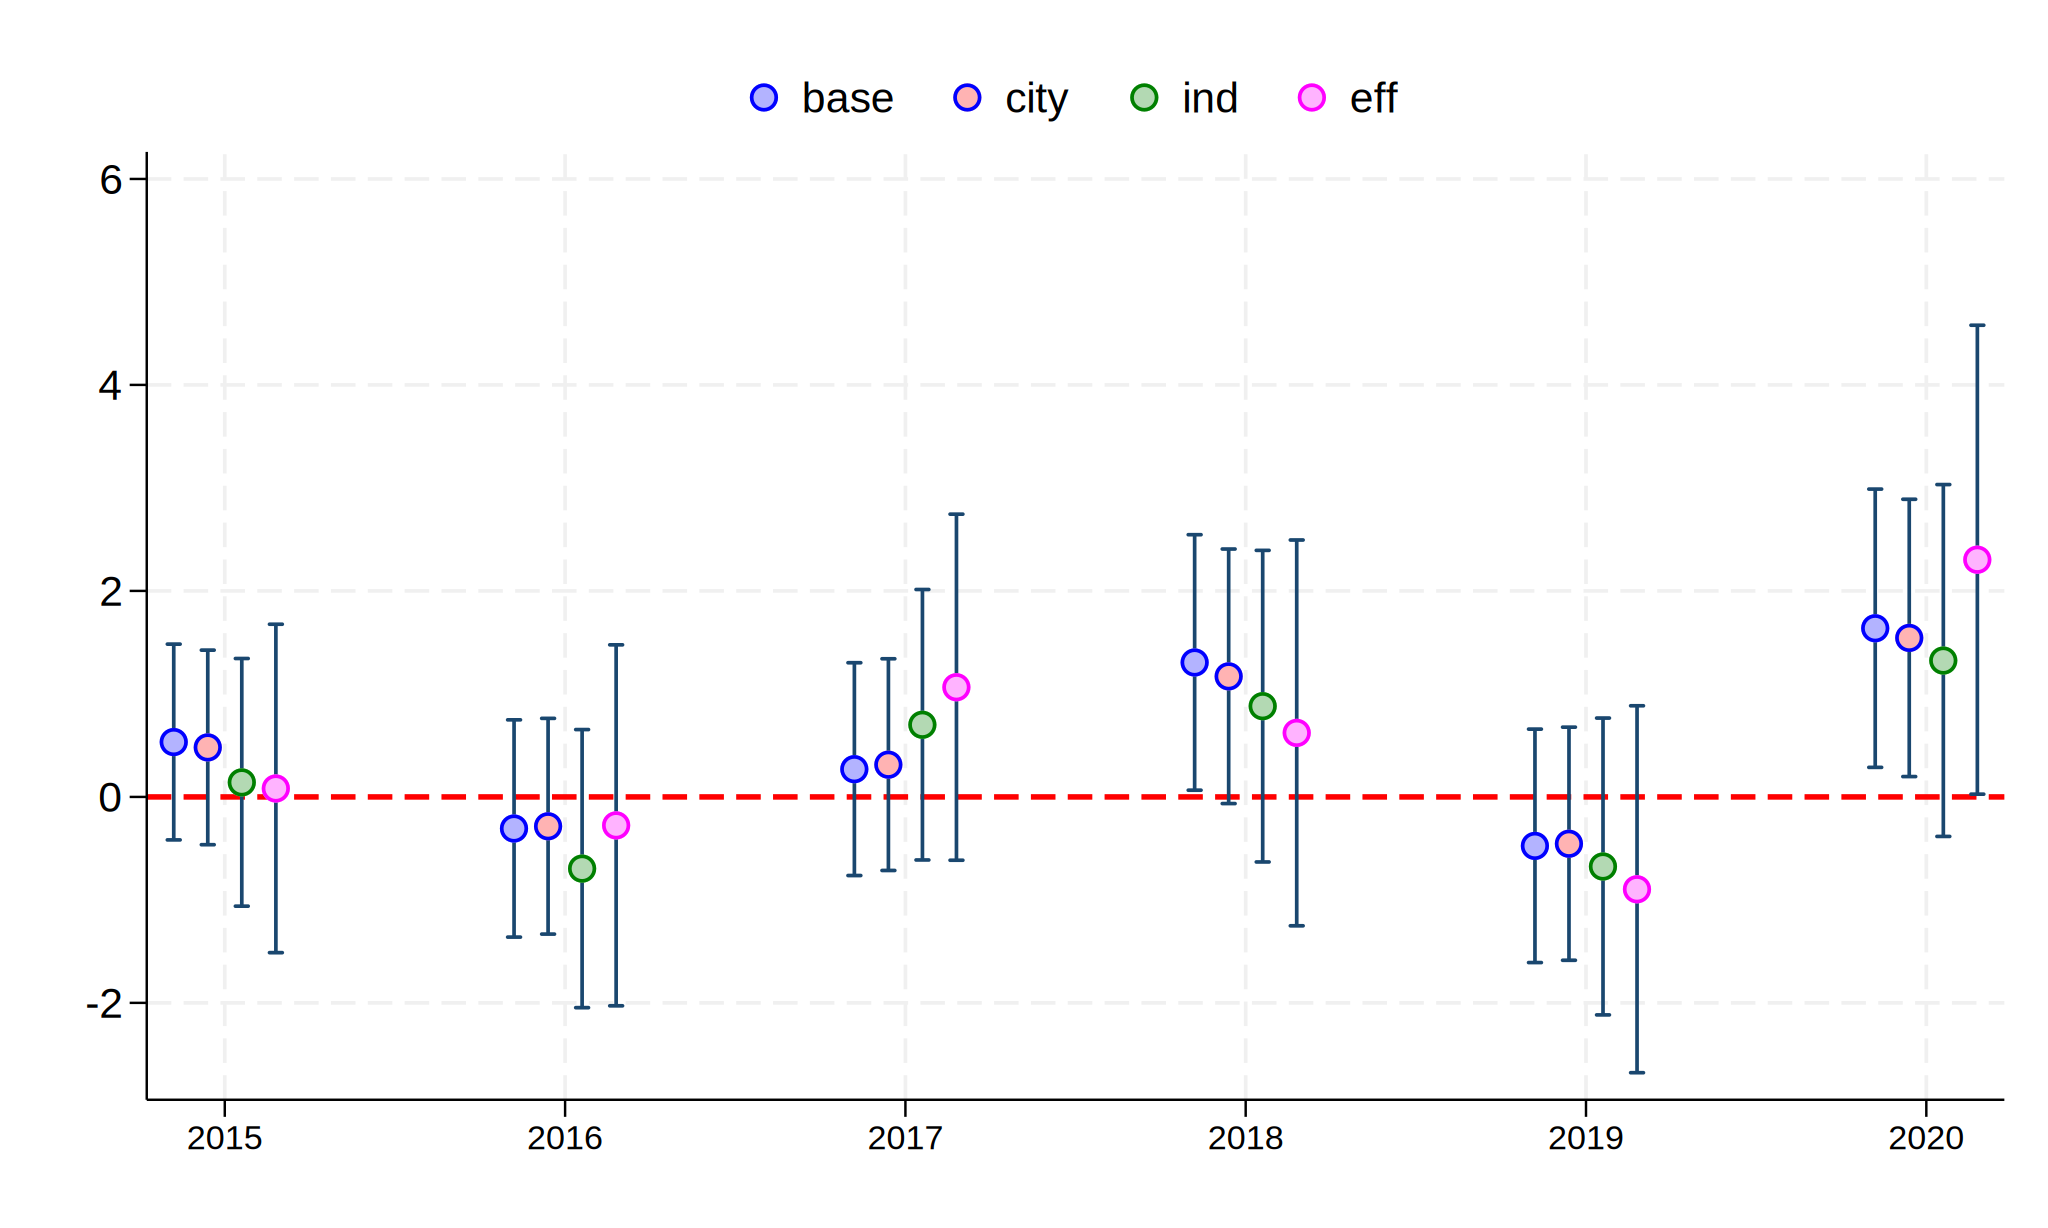

In [22]:
%%stata
#delimit;
qui{;
use suicide_f_reduced.dta,clear;
rename bvl bvl_base;
rename bup bup_base;
rename bdn bdn_base;
gen hoge=1;
merge 1:1 indx using suicide_f_reduced_city.dta;
drop _merge;
rename bvl bvl_city;
rename bup bup_city;
rename bdn bdn_city;
replace hoge=2;
merge 1:1 indx using suicide_f_reduced_ind.dta;
drop _merge;
rename bvl bvl_ind;
rename bup bup_ind;
rename bdn bdn_ind;
replace hoge=3;
merge 1:1 indx using suicide_f_reduced_eff.dta;
drop _merge;
rename bvl bvl_eff;
rename bup bup_eff;
rename bdn bdn_eff;
replace hoge=4;

gen indx1=indx-0.15;
gen indx2=indx-0.05;
gen indx3=indx+0.05;
gen indx4=indx+0.15;

local ylb =" ylabel(-2.5(0.5)6.0) yscale(range(-2.5(0.5)6.0)) ";      
twoway rcap bup_base bdn_base indx1,lcolor(navy)  || scatter bvl_base indx1,msize(2.0) ms(circle)  mlcolor(blue) mfcolor(blue*.3)  ||
rcap bup_city bdn_city indx2,lcolor(navy)  || scatter bvl_city indx2,msize(2.0) ms(circle)  mlcolor(blue) mfcolor(red*.3)  ||
rcap bup_ind bdn_ind indx3,lcolor(navy)  || scatter bvl_ind indx3,msize(2.0) ms(circle)  mlcolor(green) mfcolor(green*.3) || 
rcap bup_eff bdn_eff indx4,lcolor(navy)  || scatter bvl_eff indx4 , msize(2.0) ms(circle)  mlcolor(magenta) mfcolor(magenta*.3)
name("`nmc'`_indx'",replace)  saving("event_graph_fu20_1",replace) legend(off) title("`tt'") `ylab'
xtitle("")  xsc(range(1 `nn')) 
xlabel(0 "2015" 1 "2016" 2 "2017" 3 "2018" 4 "2019" 5 "2020",  labsize(small) angle(0))
legend(on order(2 "base" 4 "city" 6 "ind" 8 "eff") row(1) position(12))
yline(0, lcolor(red) lwidth(medthick));
};


. 
. #delimit;
delimiter now ;
. qui{;

. 


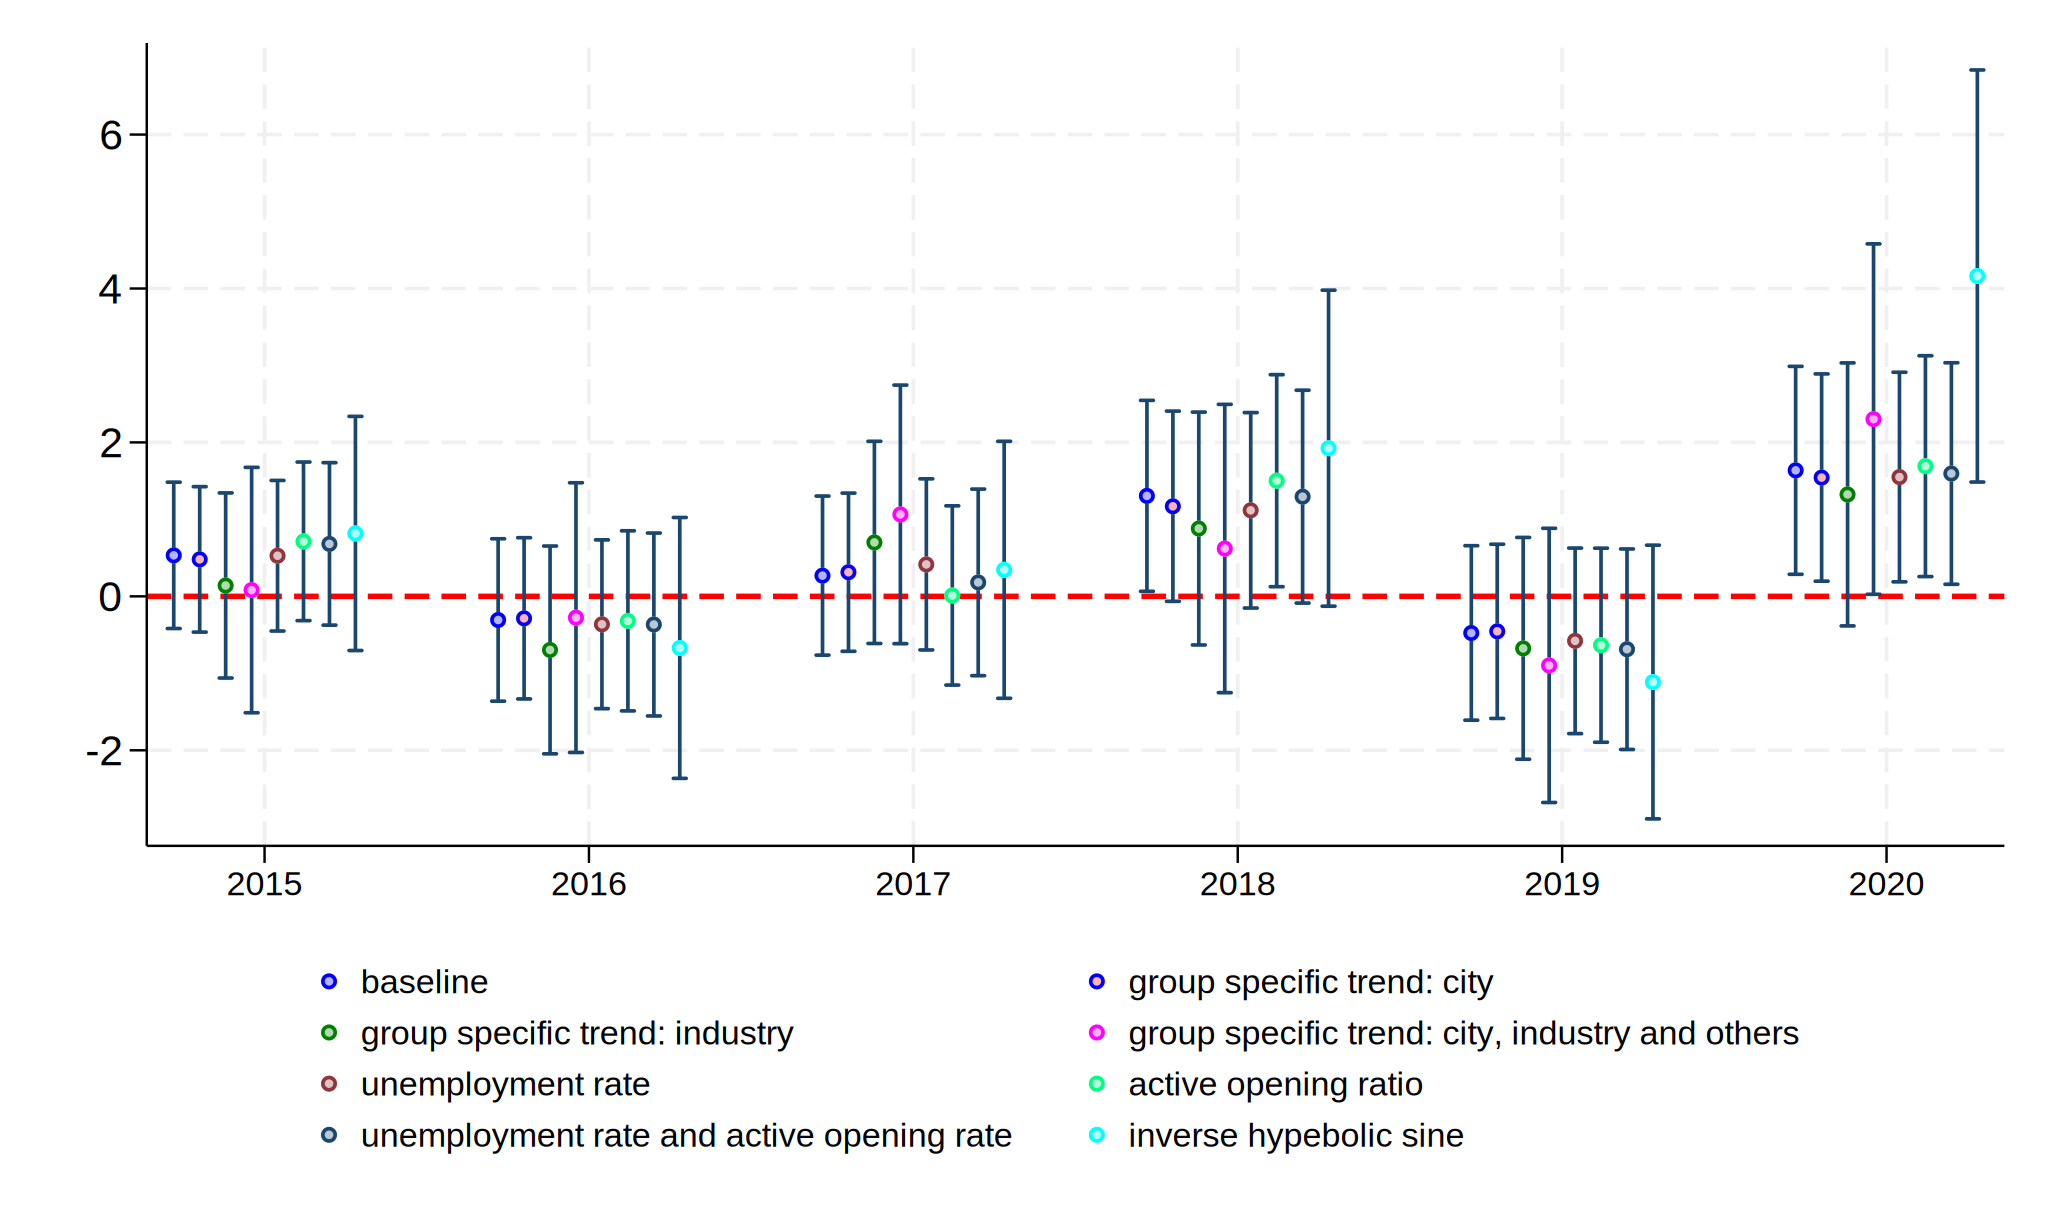

In [23]:
%%stata

#delimit;
qui{;
use suicide_f_reduced.dta,clear;
rename bvl bvl_base;
rename bup bup_base;
rename bdn bdn_base;
gen hoge=1;
merge 1:1 indx using suicide_f_reduced_city.dta;
drop _merge;
rename bvl bvl_city;
rename bup bup_city;
rename bdn bdn_city;
replace hoge=2;
merge 1:1 indx using suicide_f_reduced_ind.dta;
drop _merge;
rename bvl bvl_ind;
rename bup bup_ind;
rename bdn bdn_ind;
replace hoge=3;
merge 1:1 indx using suicide_f_reduced_eff.dta;
drop _merge;
rename bvl bvl_eff;
rename bup bup_eff;
rename bdn bdn_eff;
replace hoge=4;
merge 1:1 indx using suicide_f_reduced_unemp.dta;
drop _merge;
rename bvl bvl_unemp;
rename bup bup_unemp;
rename bdn bdn_unemp;
replace hoge=5;
merge 1:1 indx using suicide_f_reduced_actopn.dta;
drop _merge;
rename bvl bvl_actopn;
rename bup bup_actopn;
rename bdn bdn_actopn;
replace hoge=6;
merge 1:1 indx using suicide_f_reduced_une_act.dta;
drop _merge;
rename bvl bvl_une_act;
rename bup bup_une_act;
rename bdn bdn_une_act;
replace hoge=7;
merge 1:1 indx using suicide_f_reduced_ihs.dta;
drop _merge;
rename bvl bvl_ihs;
rename bup bup_ihs;
rename bdn bdn_ihs;
replace hoge=8;

gen indx1=indx-0.28;
gen indx2=indx-0.20;
gen indx3=indx-0.12;
gen indx4=indx-0.04;
gen indx5=indx+0.04;
gen indx6=indx+0.12;
gen indx7=indx+0.20;
gen indx8=indx+0.28;

local ylb =" ylabel(-2.5(0.5)6.0) yscale(range(-2.5(0.5)6.0)) ";      
twoway rcap bup_base bdn_base indx1,lcolor(navy)  || scatter bvl_base indx1,msize(1.0) ms(circle)  mlcolor(blue) mfcolor(blue*.3)  ||
rcap bup_city bdn_city indx2,lcolor(navy)  || scatter bvl_city indx2,msize(1.0) ms(circle)  mlcolor(blue) mfcolor(red*.3)  ||
rcap bup_ind bdn_ind indx3,lcolor(navy)  || scatter bvl_ind indx3,msize(1.0) ms(circle)  mlcolor(green) mfcolor(green*.3) || 
rcap bup_eff bdn_eff indx4,lcolor(navy)  || scatter bvl_eff indx4 , msize(1.0) ms(circle)  mlcolor(magenta) mfcolor(magenta*.3) ||
rcap bup_unemp bdn_unemp indx5,lcolor(navy)  || scatter bvl_unemp indx5,msize(1.0) ms(circle)  mlcolor(maroon) mfcolor(maroon*.3)  ||
rcap bup_actopn bdn_actopn indx6,lcolor(navy)  || scatter bvl_actopn indx6,msize(1.0) ms(circle)  mlcolor(mint) mfcolor(mint*.3) || 
rcap bup_une_act bdn_une_act indx7,lcolor(navy)  || scatter bvl_une_act indx7 , msize(1.0) ms(circle)  mlcolor(navy) mfcolor(navy*.3) ||
rcap bup_ihs bdn_ihs indx8,lcolor(navy)  || scatter bvl_ihs indx8 , msize(1.0) ms(circle)  mlcolor(cyan) mfcolor(cyan*.3) 
name("`nmc'`_indx'",replace)  saving("event_graph_fu20_2",replace) legend(off) title("`tt'") `ylab'
xtitle("")  xsc(range(1 `nn')) 
xlabel(0 "2015" 1 "2016" 2 "2017" 3 "2018" 4 "2019" 5 "2020",  labsize(small) angle(0))
legend(on order(2 "baseline" 4 "group specific trend: city" 6 "group specific trend: industry" 8 "group specific trend: city, industry and others" 10 "unemployment rate" 12 "active opening ratio" 14 "unemployment rate and active opening rate" 16 "inverse hypebolic sine") row(6) position(6) size(small))
yline(0, lcolor(red) lwidth(medthick));


};

## Female U20: commuting_time60_90_iv

In [24]:
%%stata
qui{
capture restore    
use ../data/suicide_analysis_data_static,clear
xtset citycode covid
    
/* Local macro */
local absvars="citycode covid"
local clsvars="citycode"
local absvars_ind "i.citycode i.covid"    
local gmm2="gmm2s"
local log_="log_"
sum suicide
local suicide_t_m=r(mean)
sum suicide_m
local suicide_m_m=r(mean)
sum suicide_f
local suicide_f_m=r(mean)
sum `log_'active_opening_ratio
local log_active_opening_ratio_m=r(mean)
sum `log_'unemployment_rate
local log_unemployment_rate_m=r(mean)
sum `log_'patient
local log_patient_m=r(mean)
sum log_active_opening_weighted
local log_active_opening_weighted_m=r(mean)
sum log_bankruptcy_debt
local log_bankruptcy_debt_m=r(mean)


* bundle commute time IV variable
local commute_time_ratio_ivs = "commuter_ratio_no commuter_ratio_u15 commuter_ratio_15_30 commuter_ratio_30_45 commuter_ratio_45_60 commuter_ratio_60_90 commuter_ratio_90_120 commuter_ratio_o120 "

* For Tables
local txt_u20="Under 20"
local txt_20_29="20-29"
local txt_30_39="30-39"
local txt_40_49="40-49"
local txt_50_59="50-59"
local txt_o60="60 or over"

/* Transformation of log(1+var) */
local paracomp_ct_1st="(commuting_time60_90_iv: _b[D1.commuting_time_iv])  "

local paracomp_f_stayhome="(stay_home: _b[D.stay_home]*(1+`suicide_f_m')/(`suicide_f_m')) "
local paracomp_f_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_f_m')/(`suicide_f_m'))  "
local paracomp_f_ct_reduced="(commuting_time60_90_iv: _b[commuting_time60_90_iv]*(1+`suicide_f_m')/(`suicide_f_m'))  "

local paracomp_m_stayhome="(stay_home: _b[D.stay_home]*(1+`suicide_m_m')/(`suicide_m_m')) "
local paracomp_m_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_m_m')/(`suicide_m_m'))  "
local paracomp_m_ct_reduced="(commuting_time60_90_iv_iv: _b[commuting_time60_90_iv]*(1+`suicide_m_m')/(`suicide_m_m'))  "
}


. qui{

. 


In [25]:
%%stata
qui{
sum suicide_u20
local suicide_f_m=r(mean)
local paracomp_m_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_f_m')/(`suicide_f_m'))  "
save temp,replace    
}


. qui{

. 


In [26]:
%%stata
qui{
use  temp,replace   
reghdfe D.suicide_f_u20_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0
preserve
}


. qui{

. 


In [27]:
%%stata
qui{
capture restore    
use temp,clear
preserve
use ../data/suicide_analysis_data,clear


collapse (sum) suicide_f_u20 (first) prefecture cityname,by(citycode year)
rename suicide_f_u20 suicide_f_u20_
reshape wide suicide_f_u20, i(citycode)  j(year)
save suicide_f_u20_past,replace
restore
merge m:1 citycode using suicide_f_u20_past,keepusing(suicide_f_u20_*)
drop _merge

gen suicide_f_u20_14_log=log(1+suicide_f_u20_2014)
gen suicide_f_u20_15_log=log(1+suicide_f_u20_2015)
gen suicide_f_u20_16_log=log(1+suicide_f_u20_2016)
gen suicide_f_u20_17_log=log(1+suicide_f_u20_2017)
gen suicide_f_u20_18_log=log(1+suicide_f_u20_2018)
gen suicide_f_u20_19_log=log(1+suicide_f_u20_2019)

gen D1_suicide_f_u20_log=suicide_f_u20_19_log-suicide_f_u20_18_log
gen D2_suicide_f_u20_log=suicide_f_u20_18_log-suicide_f_u20_17_log
gen D3_suicide_f_u20_log=suicide_f_u20_17_log-suicide_f_u20_16_log
gen D4_suicide_f_u20_log=suicide_f_u20_16_log-suicide_f_u20_15_log
gen D5_suicide_f_u20_log=suicide_f_u20_15_log-suicide_f_u20_14_log
   
local clsvars="citycode"
xtset citycode covid
             


reghdfe D.suicide_f_u20_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0

reghdfe  D1_suicide_f_u20_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1
reghdfe  D2_suicide_f_u20_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2
reghdfe  D3_suicide_f_u20_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3
reghdfe  D4_suicide_f_u20_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4
reghdfe  D5_suicide_f_u20_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5
                                                        
coefplot suicide_f_reduced5 ,bylabel(2015)|| suicide_f_reduced4 ,bylabel(2016) || suicide_f_reduced3  ,bylabel(2017)  || suicide_f_reduced2  ,bylabel(2018)  || suicide_f_reduced1  ,bylabel(2019)  || suicide_f_reduced0 , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw
                                                           
preserve
}                                                           


. qui{

. 


In [28]:
%%stata

#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t';
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. 
. #delimit;
delimiter now ;
. qui{;

. 


### WITH CONTROL

In [29]:
%%stata 
qui{
global city_ind_large_eff_lev_controls "is_city industry_large_1_15 industry_large_2_15 industry_large_3_15 young_rate self_employee_rate labor_force_rate single_household_ratio "
}



. qui{

. 


In [30]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0_city

reghdfe  D1_suicide_f_u20_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_city
reghdfe  D2_suicide_f_u20_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_city
reghdfe  D3_suicide_f_u20_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_city
reghdfe  D4_suicide_f_u20_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_city
reghdfe  D5_suicide_f_u20_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_city

coefplot suicide_f_reduced5_city ,bylabel(2015)|| suicide_f_reduced4_city ,bylabel(2016) || suicide_f_reduced3_city  ,bylabel(2017)  || suicide_f_reduced2_city  ,bylabel(2018)  || suicide_f_reduced1_city  ,bylabel(2019)  || suicide_f_reduced0_city , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace)  nodraw
preserve
}



. qui{

. 


In [31]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_city;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_city.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [32]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0_ind

reghdfe  D1_suicide_f_u20_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_ind
reghdfe  D2_suicide_f_u20_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_ind
reghdfe  D3_suicide_f_u20_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_ind
reghdfe  D4_suicide_f_u20_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_ind
reghdfe  D5_suicide_f_u20_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_ind

coefplot suicide_f_reduced5_ind ,bylabel(2015)|| suicide_f_reduced4_ind ,bylabel(2016) || suicide_f_reduced3_ind  ,bylabel(2017)  || suicide_f_reduced2_ind  ,bylabel(2018)  || suicide_f_reduced1_ind  ,bylabel(2019)  || suicide_f_reduced0_ind , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw
preserve
}


. qui{

. 


In [33]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_ind;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_ind.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [34]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0_eff

reghdfe  D1_suicide_f_u20_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_eff
reghdfe  D2_suicide_f_u20_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_eff
reghdfe  D3_suicide_f_u20_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_eff
reghdfe  D4_suicide_f_u20_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_eff
reghdfe  D5_suicide_f_u20_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_eff

coefplot suicide_f_reduced5_eff ,bylabel(2015)|| suicide_f_reduced4_eff ,bylabel(2016) || suicide_f_reduced3_eff  ,bylabel(2017)  || suicide_f_reduced2_eff  ,bylabel(2018)  || suicide_f_reduced1_eff  ,bylabel(2019)  || suicide_f_reduced0_eff , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [35]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_eff;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_eff.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [36]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0_unemp

reghdfe  D1_suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_unemp
reghdfe  D2_suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_unemp
reghdfe  D3_suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_unemp
reghdfe  D4_suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_unemp
reghdfe  D5_suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_unemp

coefplot suicide_f_reduced5_unemp ,bylabel(2015)|| suicide_f_reduced4_unemp ,bylabel(2016) || suicide_f_reduced3_unemp  ,bylabel(2017)  || suicide_f_reduced2_unemp  ,bylabel(2018)  || suicide_f_reduced1_unemp  ,bylabel(2019)  || suicide_f_reduced0_unemp , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [37]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_unemp;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_unemp.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [38]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced0_actopn

reghdfe  D1_suicide_f_u20_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_actopn
reghdfe  D2_suicide_f_u20_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_actopn
reghdfe  D3_suicide_f_u20_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_actopn
reghdfe  D4_suicide_f_u20_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_actopn
reghdfe  D5_suicide_f_u20_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_actopn

coefplot suicide_f_reduced5_actopn ,bylabel(2015)|| suicide_f_reduced4_actopn ,bylabel(2016) || suicide_f_reduced3_actopn  ,bylabel(2017)  || suicide_f_reduced2_actopn  ,bylabel(2018)  || suicide_f_reduced1_actopn  ,bylabel(2019)  || suicide_f_reduced0_actopn , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [39]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_actopn;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_actopn.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [40]:
%%stata
qui{
capture restore
reghdfe D.suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store  suicide_f_reduced0_une_act

reghdfe  D1_suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced1_une_act
reghdfe  D2_suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced2_une_act
reghdfe  D3_suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced3_une_act
reghdfe  D4_suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced4_une_act
reghdfe  D5_suicide_f_u20_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_f_reduced5_une_act

coefplot suicide_f_reduced5_une_act ,bylabel(2015)|| suicide_f_reduced4_une_act ,bylabel(2016) || suicide_f_reduced3_une_act  ,bylabel(2017)  || suicide_f_reduced2_une_act  ,bylabel(2018)  || suicide_f_reduced1_une_act  ,bylabel(2019)  || suicide_f_reduced0_une_act , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [41]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_une_act;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_une_act.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [42]:
%%stata
qui{
local paracomp_f_ct_ihs_reduced="(commuting_time60_90_iv: _b[commuting_time60_90_iv]*((sqrt(`suicide_f_m'^2+1))/`suicide_f_m')) "

capture restore

reghdfe D.suicide_f_u20_ihs commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced0_ihs

reghdfe  D1_suicide_f_u20_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced1_ihs
reghdfe  D2_suicide_f_u20_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced2_ihs
reghdfe  D3_suicide_f_u20_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced3_ihs
reghdfe  D4_suicide_f_u20_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced4_ihs
reghdfe  D5_suicide_f_u20_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_ihs_reduced', post
est store suicide_f_reduced5_ihs

coefplot suicide_f_reduced5_ihs ,bylabel(2015)|| suicide_f_reduced4_ihs ,bylabel(2016) || suicide_f_reduced3_ihs  ,bylabel(2017)  || suicide_f_reduced2_ihs  ,bylabel(2018)  || suicide_f_reduced1_ihs  ,bylabel(2019)  || suicide_f_reduced0_ihs , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [43]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_f_reduced`t'_ihs;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_f_reduced_ihs.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


### Combine Graphs


. #delimit;
delimiter now ;
. qui{;

. 


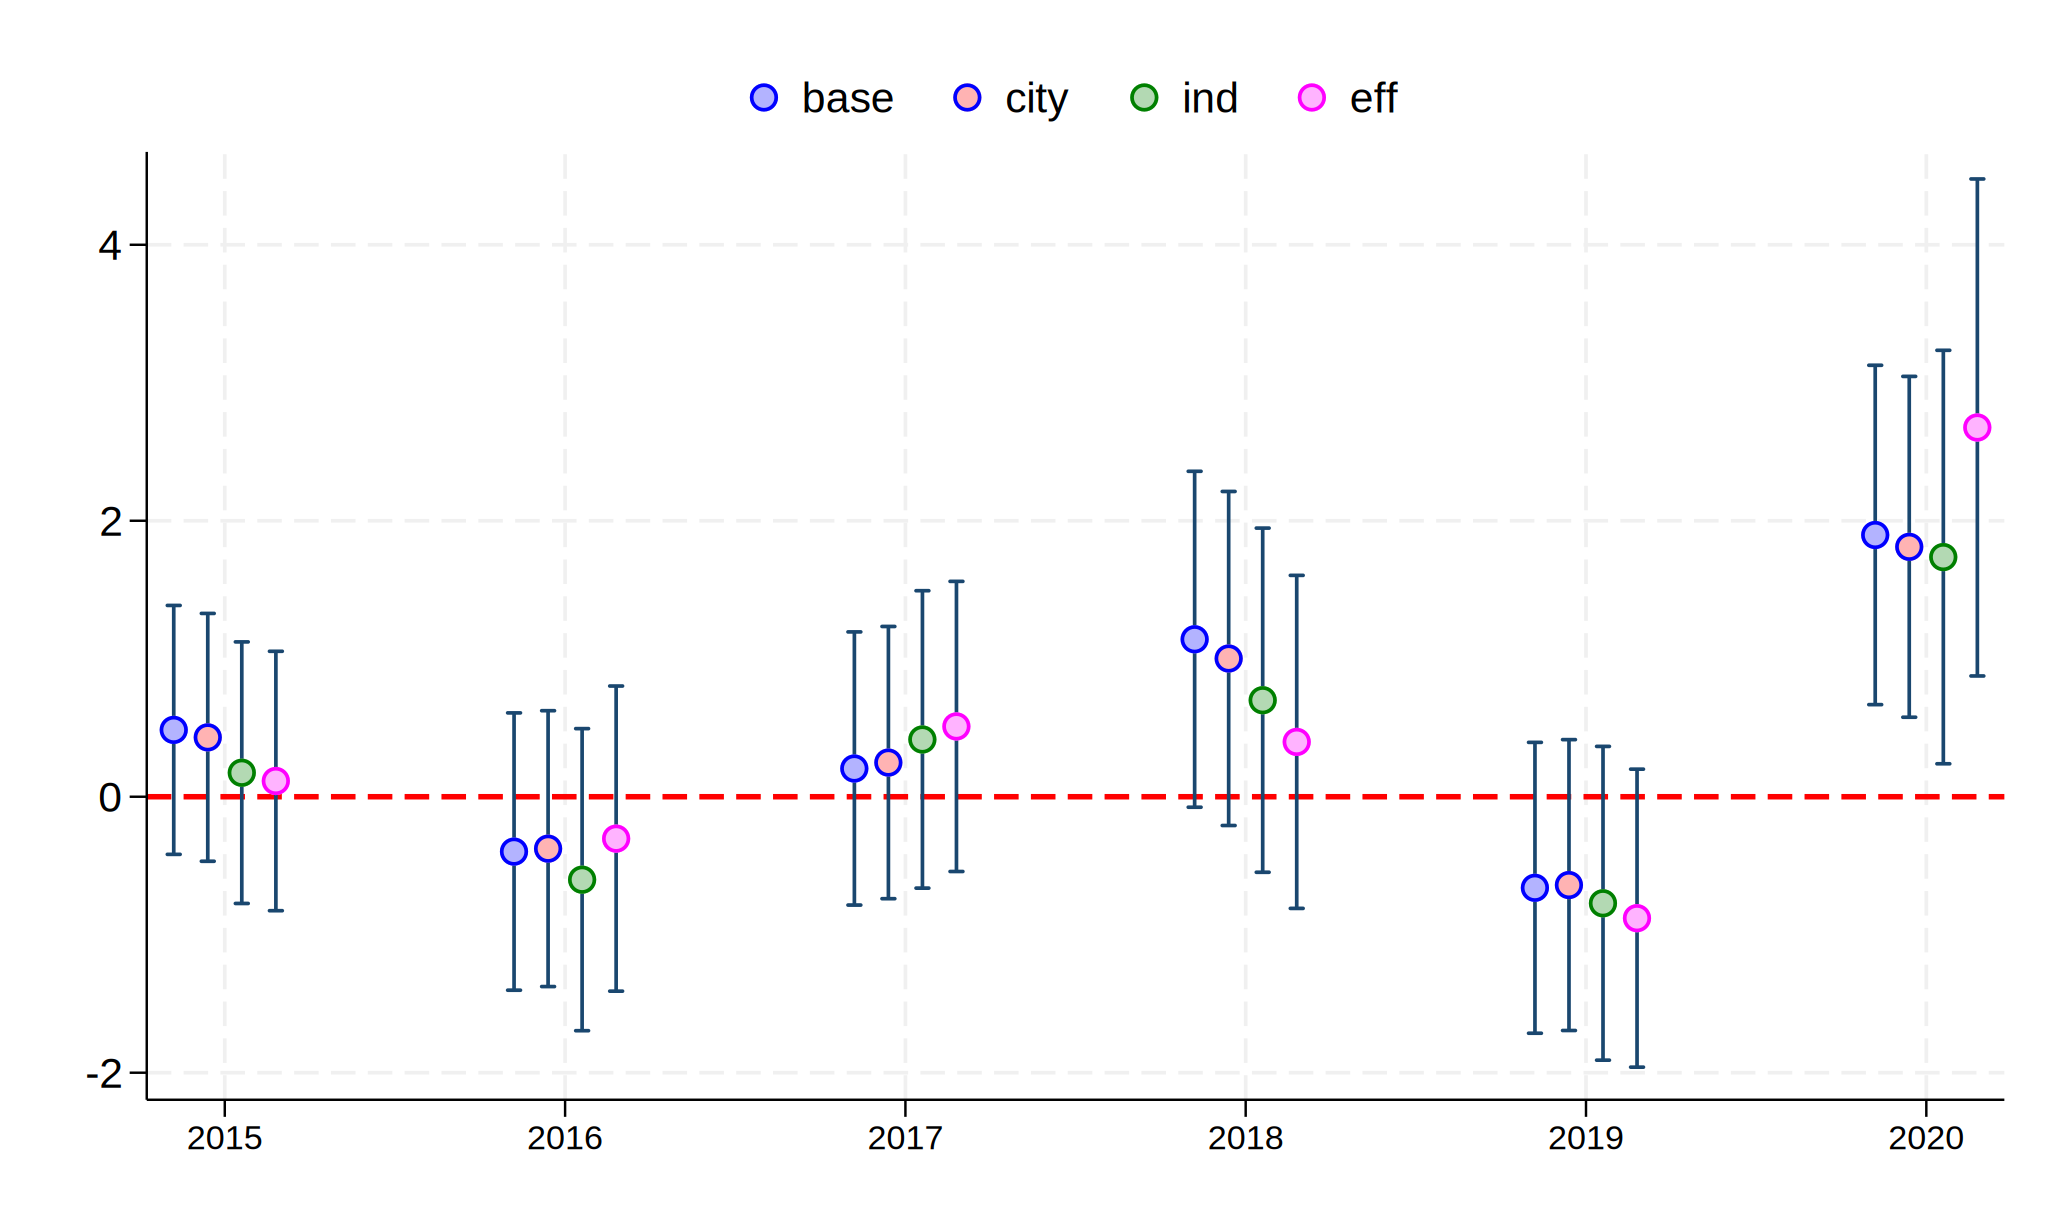

In [44]:
%%stata
#delimit;
qui{;
use suicide_f_reduced.dta,clear;
rename bvl bvl_base;
rename bup bup_base;
rename bdn bdn_base;
gen hoge=1;
merge 1:1 indx using suicide_f_reduced_city.dta;
drop _merge;
rename bvl bvl_city;
rename bup bup_city;
rename bdn bdn_city;
replace hoge=2;
merge 1:1 indx using suicide_f_reduced_ind.dta;
drop _merge;
rename bvl bvl_ind;
rename bup bup_ind;
rename bdn bdn_ind;
replace hoge=3;
merge 1:1 indx using suicide_f_reduced_eff.dta;
drop _merge;
rename bvl bvl_eff;
rename bup bup_eff;
rename bdn bdn_eff;
replace hoge=4;

gen indx1=indx-0.15;
gen indx2=indx-0.05;
gen indx3=indx+0.05;
gen indx4=indx+0.15;

local ylb =" ylabel(-2.5(0.5)6.0) yscale(range(-2.5(0.5)6.0)) ";      
twoway rcap bup_base bdn_base indx1,lcolor(navy)  || scatter bvl_base indx1,msize(2.0) ms(circle)  mlcolor(blue) mfcolor(blue*.3)  ||
rcap bup_city bdn_city indx2,lcolor(navy)  || scatter bvl_city indx2,msize(2.0) ms(circle)  mlcolor(blue) mfcolor(red*.3)  ||
rcap bup_ind bdn_ind indx3,lcolor(navy)  || scatter bvl_ind indx3,msize(2.0) ms(circle)  mlcolor(green) mfcolor(green*.3) || 
rcap bup_eff bdn_eff indx4,lcolor(navy)  || scatter bvl_eff indx4 , msize(2.0) ms(circle)  mlcolor(magenta) mfcolor(magenta*.3)
name("`nmc'`_indx'",replace)  saving("event_graph_fu20_1_single_iv",replace) legend(off) title("`tt'") `ylab'
xtitle("")  xsc(range(1 `nn')) 
xlabel(0 "2015" 1 "2016" 2 "2017" 3 "2018" 4 "2019" 5 "2020",  labsize(small) angle(0))
legend(on order(2 "base" 4 "city" 6 "ind" 8 "eff") row(1) position(12))
yline(0, lcolor(red) lwidth(medthick));
};


. 
. #delimit;
delimiter now ;
. qui{;

. 


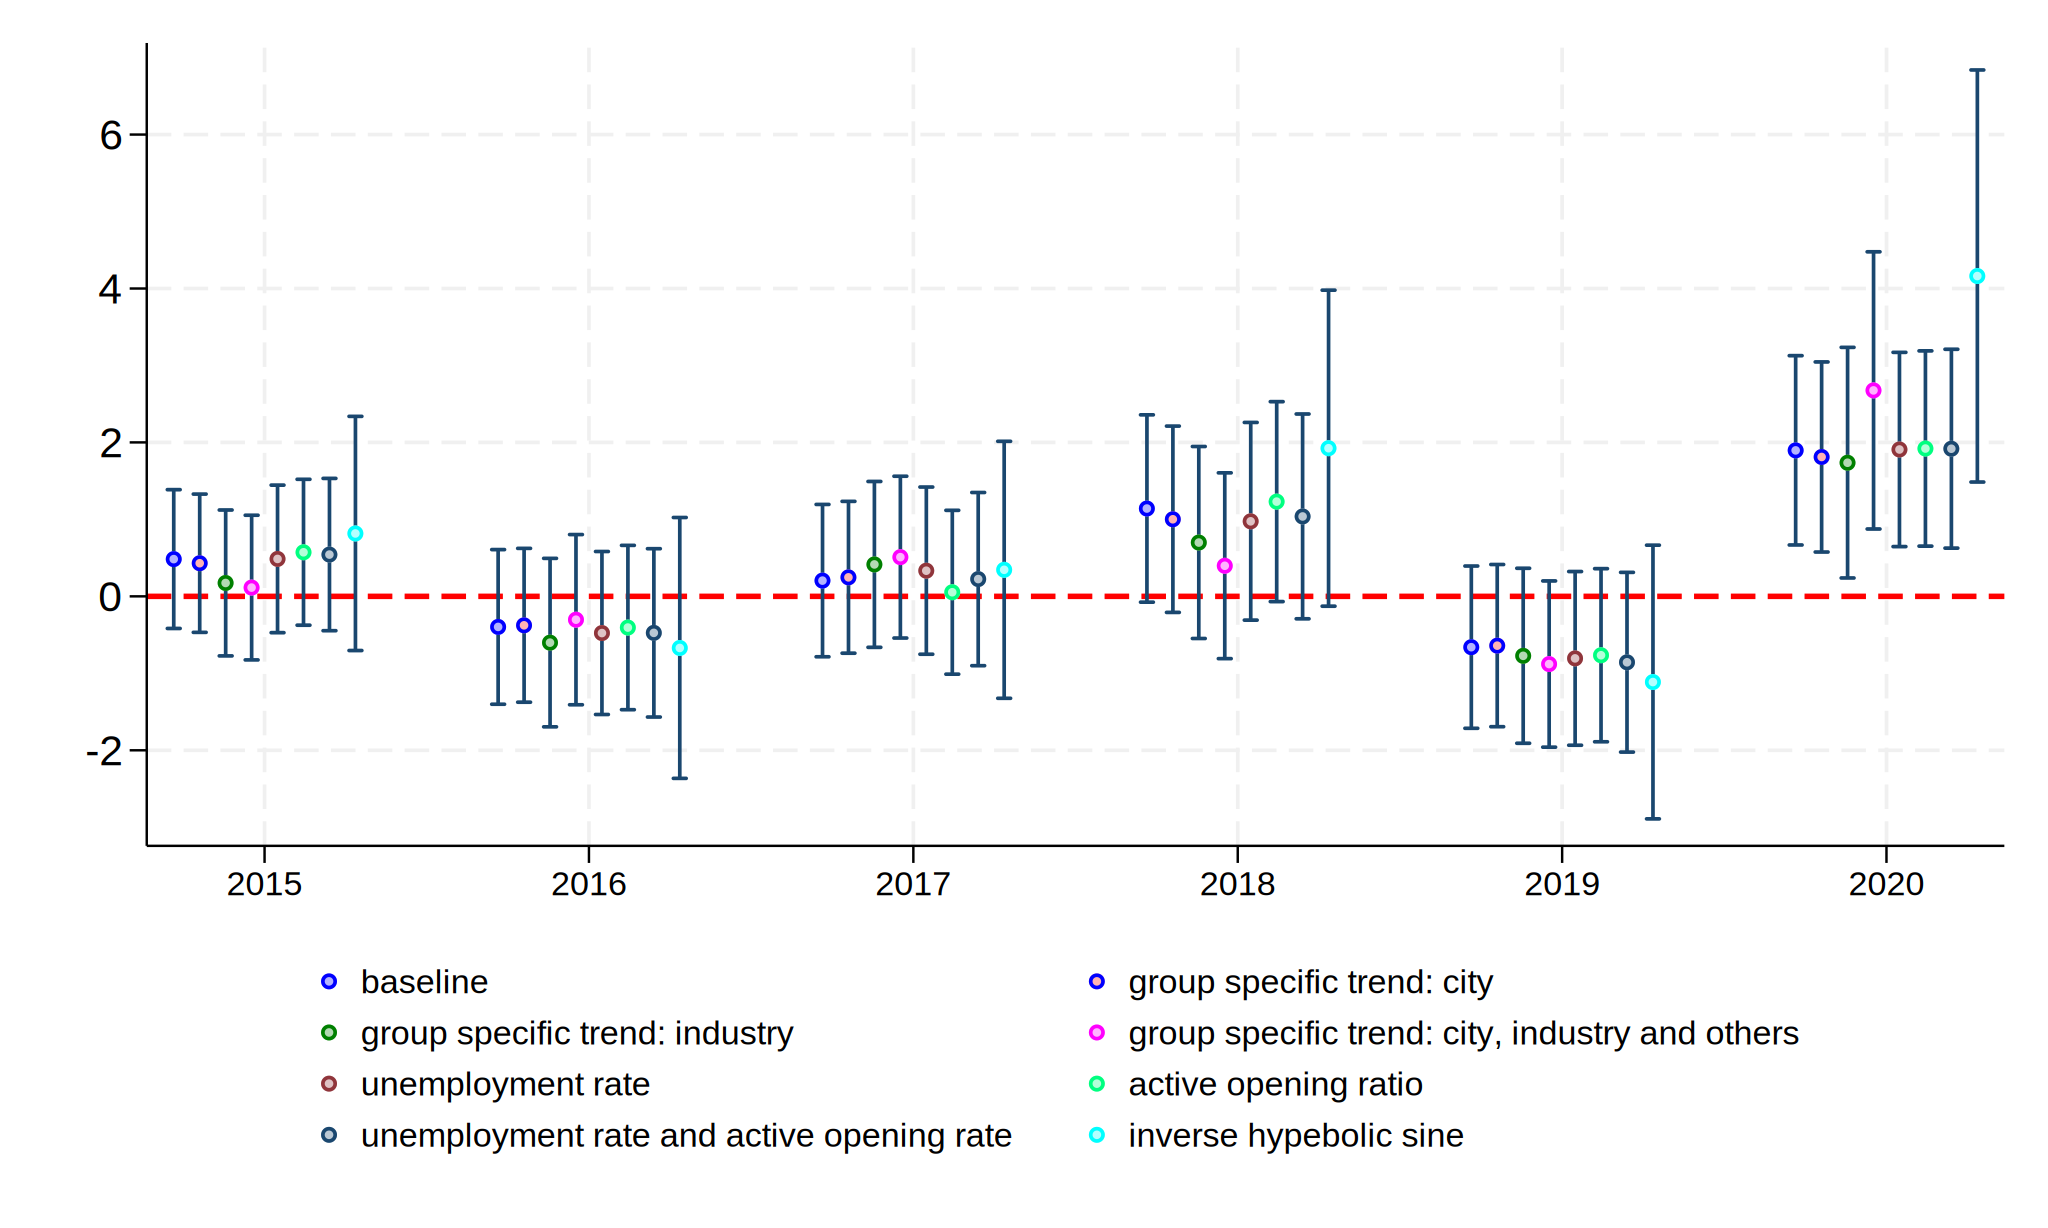

In [45]:
%%stata

#delimit;
qui{;
use suicide_f_reduced.dta,clear;
rename bvl bvl_base;
rename bup bup_base;
rename bdn bdn_base;
gen hoge=1;
merge 1:1 indx using suicide_f_reduced_city.dta;
drop _merge;
rename bvl bvl_city;
rename bup bup_city;
rename bdn bdn_city;
replace hoge=2;
merge 1:1 indx using suicide_f_reduced_ind.dta;
drop _merge;
rename bvl bvl_ind;
rename bup bup_ind;
rename bdn bdn_ind;
replace hoge=3;
merge 1:1 indx using suicide_f_reduced_eff.dta;
drop _merge;
rename bvl bvl_eff;
rename bup bup_eff;
rename bdn bdn_eff;
replace hoge=4;
merge 1:1 indx using suicide_f_reduced_unemp.dta;
drop _merge;
rename bvl bvl_unemp;
rename bup bup_unemp;
rename bdn bdn_unemp;
replace hoge=5;
merge 1:1 indx using suicide_f_reduced_actopn.dta;
drop _merge;
rename bvl bvl_actopn;
rename bup bup_actopn;
rename bdn bdn_actopn;
replace hoge=6;
merge 1:1 indx using suicide_f_reduced_une_act.dta;
drop _merge;
rename bvl bvl_une_act;
rename bup bup_une_act;
rename bdn bdn_une_act;
replace hoge=7;
merge 1:1 indx using suicide_f_reduced_ihs.dta;
drop _merge;
rename bvl bvl_ihs;
rename bup bup_ihs;
rename bdn bdn_ihs;
replace hoge=8;

gen indx1=indx-0.28;
gen indx2=indx-0.20;
gen indx3=indx-0.12;
gen indx4=indx-0.04;
gen indx5=indx+0.04;
gen indx6=indx+0.12;
gen indx7=indx+0.20;
gen indx8=indx+0.28;

local ylb =" ylabel(-2.5(0.5)6.0) yscale(range(-2.5(0.5)6.0)) ";      
twoway rcap bup_base bdn_base indx1,lcolor(navy)  || scatter bvl_base indx1,msize(1.0) ms(circle)  mlcolor(blue) mfcolor(blue*.3)  ||
rcap bup_city bdn_city indx2,lcolor(navy)  || scatter bvl_city indx2,msize(1.0) ms(circle)  mlcolor(blue) mfcolor(red*.3)  ||
rcap bup_ind bdn_ind indx3,lcolor(navy)  || scatter bvl_ind indx3,msize(1.0) ms(circle)  mlcolor(green) mfcolor(green*.3) || 
rcap bup_eff bdn_eff indx4,lcolor(navy)  || scatter bvl_eff indx4 , msize(1.0) ms(circle)  mlcolor(magenta) mfcolor(magenta*.3) ||
rcap bup_unemp bdn_unemp indx5,lcolor(navy)  || scatter bvl_unemp indx5,msize(1.0) ms(circle)  mlcolor(maroon) mfcolor(maroon*.3)  ||
rcap bup_actopn bdn_actopn indx6,lcolor(navy)  || scatter bvl_actopn indx6,msize(1.0) ms(circle)  mlcolor(mint) mfcolor(mint*.3) || 
rcap bup_une_act bdn_une_act indx7,lcolor(navy)  || scatter bvl_une_act indx7 , msize(1.0) ms(circle)  mlcolor(navy) mfcolor(navy*.3) ||
rcap bup_ihs bdn_ihs indx8,lcolor(navy)  || scatter bvl_ihs indx8 , msize(1.0) ms(circle)  mlcolor(cyan) mfcolor(cyan*.3) 
name("`nmc'`_indx'",replace)  saving("event_graph_fu20_2_single_iv",replace) legend(off) title("`tt'") `ylab'
xtitle("")  xsc(range(1 `nn')) 
xlabel(0 "2015" 1 "2016" 2 "2017" 3 "2018" 4 "2019" 5 "2020",  labsize(small) angle(0))
legend(on order(2 "baseline" 4 "group specific trend: city" 6 "group specific trend: industry" 8 "group specific trend: city, industry and others" 10 "unemployment rate" 12 "active opening ratio" 14 "unemployment rate and active opening rate" 16 "inverse hypebolic sine") row(6) position(6) size(small))
yline(0, lcolor(red) lwidth(medthick));


};

## Male 40-49: commuting_time_iv

In [46]:
%%stata
qui{
capture restore    
use ../data/suicide_analysis_data_static,clear
xtset citycode covid
    
/* Local macro */
local absvars="citycode covid"
local clsvars="citycode"
local absvars_ind "i.citycode i.covid"    
local gmm2="gmm2s"
local log_="log_"
sum suicide
local suicide_t_m=r(mean)
sum suicide_m
local suicide_m_m=r(mean)
sum suicide_f
local suicide_f_m=r(mean)
sum `log_'active_opening_ratio
local log_active_opening_ratio_m=r(mean)
sum `log_'unemployment_rate
local log_unemployment_rate_m=r(mean)
sum `log_'patient
local log_patient_m=r(mean)
sum log_active_opening_weighted
local log_active_opening_weighted_m=r(mean)
sum log_bankruptcy_debt
local log_bankruptcy_debt_m=r(mean)


* bundle commute time IV variable
local commute_time_ratio_ivs = "commuter_ratio_no commuter_ratio_u15 commuter_ratio_15_30 commuter_ratio_30_45 commuter_ratio_45_60 commuter_ratio_60_90 commuter_ratio_90_120 commuter_ratio_o120 "

* For Tables
local txt_u20="Under 20"
local txt_20_29="20-29"
local txt_30_39="30-39"
local txt_40_49="40-49"
local txt_50_59="50-59"
local txt_o60="60 or over"

/* Transformation of log(1+var) */
local paracomp_ct_1st="(D_commuting_time_iv: _b[D1.commuting_time_iv])  "

local paracomp_f_stayhome="(stay_home: _b[D.stay_home]*(1+`suicide_f_m')/(`suicide_f_m')) "
local paracomp_f_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_f_m')/(`suicide_f_m'))  "
local paracomp_f_ct_reduced="(D_commuting_time_iv: _b[D_commuting_time_iv]*(1+`suicide_f_m')/(`suicide_f_m'))  "

local paracomp_m_stayhome="(stay_home: _b[D.stay_home]*(1+`suicide_m_m')/(`suicide_m_m')) "
local paracomp_m_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_m_m')/(`suicide_m_m'))  "
local paracomp_m_ct_reduced="(D_commuting_time_iv: _b[D_commuting_time_iv]*(1+`suicide_m_m')/(`suicide_m_m'))  "
}


. qui{

. 


In [47]:
%%stata
qui{
sum suicide_m_40_49
local suicide_m_m=r(mean)
local paracomp_m_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_m_m')/(`suicide_m_m'))  "
save temp,replace    
}


. qui{

. 


In [48]:
%%stata
qui{
use  temp,replace   
reghdfe D.suicide_m_40_49_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced0
preserve
}


. qui{

. 


In [49]:
%%stata
qui{
capture restore    
use temp,clear
preserve
use ../data/suicide_analysis_data,clear


collapse (sum) suicide_m_40_49 (first) prefecture cityname,by(citycode year)
rename suicide_m_40_49 suicide_m_40_49_
reshape wide suicide_m_40_49, i(citycode)  j(year)
save suicide_m_40_49_past,replace
restore
merge m:1 citycode using suicide_m_40_49_past,keepusing(suicide_m_40_49_*)
drop _merge

gen suicide_m_40_49_14_log=log(1+suicide_m_40_49_2014)
gen suicide_m_40_49_15_log=log(1+suicide_m_40_49_2015)
gen suicide_m_40_49_16_log=log(1+suicide_m_40_49_2016)
gen suicide_m_40_49_17_log=log(1+suicide_m_40_49_2017)
gen suicide_m_40_49_18_log=log(1+suicide_m_40_49_2018)
gen suicide_m_40_49_19_log=log(1+suicide_m_40_49_2019)

gen D1_suicide_m_40_49_log=suicide_m_40_49_19_log-suicide_m_40_49_18_log
gen D2_suicide_m_40_49_log=suicide_m_40_49_18_log-suicide_m_40_49_17_log
gen D3_suicide_m_40_49_log=suicide_m_40_49_17_log-suicide_m_40_49_16_log
gen D4_suicide_m_40_49_log=suicide_m_40_49_16_log-suicide_m_40_49_15_log
gen D5_suicide_m_40_49_log=suicide_m_40_49_15_log-suicide_m_40_49_14_log
   
local clsvars="citycode"
xtset citycode covid
             


reghdfe D.suicide_m_40_49_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_40_49reduced0

reghdfe  D1_suicide_m_40_49_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1
reghdfe  D2_suicide_m_40_49_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2
reghdfe  D3_suicide_m_40_49_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3
reghdfe  D4_suicide_m_40_49_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4
reghdfe  D5_suicide_m_40_49_log D_commuting_time_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5
                                                        
coefplot suicide_m_reduced5 ,bylabel(2015)|| suicide_m_reduced4 ,bylabel(2016) || suicide_m_reduced3  ,bylabel(2017)  || suicide_m_reduced2  ,bylabel(2018)  || suicide_m_reduced1  ,bylabel(2019)  || suicide_m_reduced0 , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw
                                                           
preserve
}                                                     


. qui{

. 


In [50]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t';
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


### WITH CONTROL

In [51]:
%%stata 
qui{
global city_ind_large_eff_lev_controls "is_city industry_large_1_15 industry_large_2_15 industry_large_3_15 young_rate self_employee_rate labor_force_rate single_household_ratio "
}


. qui{

. 


In [52]:
%%stata
qui{
restore
reghdfe D.suicide_m_40_49_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced0_city

reghdfe  D1_suicide_m_40_49_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1_city
reghdfe  D2_suicide_m_40_49_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2_city
reghdfe  D3_suicide_m_40_49_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3_city
reghdfe  D4_suicide_m_40_49_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4_city
reghdfe  D5_suicide_m_40_49_log D_commuting_time_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5_city

coefplot suicide_m_reduced5_city ,bylabel(2015)|| suicide_m_reduced4_city ,bylabel(2016) || suicide_m_reduced3_city  ,bylabel(2017)  || suicide_m_reduced2_city  ,bylabel(2018)  || suicide_m_reduced1_city  ,bylabel(2019)  || suicide_m_reduced0_city , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw
preserve 

}


. qui{

. 


In [53]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_city;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_city.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [54]:
%%stata
qui{
restore
reghdfe D.suicide_m_40_49_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced0_ind

reghdfe  D1_suicide_m_40_49_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced1_ind
reghdfe  D2_suicide_m_40_49_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced2_ind
reghdfe  D3_suicide_m_40_49_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced3_ind
reghdfe  D4_suicide_m_40_49_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced4_ind
reghdfe  D5_suicide_m_40_49_log D_commuting_time_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced5_ind

coefplot suicide_m_reduced5_ind ,bylabel(2015)|| suicide_m_reduced4_ind ,bylabel(2016) || suicide_m_reduced3_ind  ,bylabel(2017)  || suicide_m_reduced2_ind  ,bylabel(2018)  || suicide_m_reduced1_ind  ,bylabel(2019)  || suicide_m_reduced0_ind , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw
preserve
}


. qui{

. 


In [55]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_ind;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_ind.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [56]:
%%stata
qui{
restore
reghdfe D.suicide_m_40_49_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced0_eff

reghdfe  D1_suicide_m_40_49_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1_eff
reghdfe  D2_suicide_m_40_49_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2_eff
reghdfe  D3_suicide_m_40_49_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3_eff
reghdfe  D4_suicide_m_40_49_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4_eff
reghdfe  D5_suicide_m_40_49_log D_commuting_time_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5_eff

coefplot suicide_m_reduced5_eff ,bylabel(2015)|| suicide_m_reduced4_eff ,bylabel(2016) || suicide_m_reduced3_eff  ,bylabel(2017)  || suicide_m_reduced2_eff  ,bylabel(2018)  || suicide_m_reduced1_eff  ,bylabel(2019)  || suicide_m_reduced0_eff , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [57]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_eff;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_eff.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [58]:
%%stata
qui{
capture restore
reghdfe D.suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced0_unemp

reghdfe  D1_suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1_unemp
reghdfe  D2_suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2_unemp
reghdfe  D3_suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3_unemp
reghdfe  D4_suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4_unemp
reghdfe  D5_suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5_unemp

coefplot suicide_m_reduced5_unemp ,bylabel(2015)|| suicide_m_reduced4_unemp ,bylabel(2016) || suicide_m_reduced3_unemp  ,bylabel(2017)  || suicide_m_reduced2_unemp  ,bylabel(2018)  || suicide_m_reduced1_unemp  ,bylabel(2019)  || suicide_m_reduced0_unemp , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [59]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_unemp;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_unemp.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [60]:
%%stata
qui{
restore
reghdfe D.suicide_m_40_49_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced0_actopn

reghdfe  D1_suicide_m_40_49_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1_actopn
reghdfe  D2_suicide_m_40_49_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2_actopn
reghdfe  D3_suicide_m_40_49_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3_actopn
reghdfe  D4_suicide_m_40_49_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4_actopn
reghdfe  D5_suicide_m_40_49_log D_commuting_time_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5_actopn

coefplot suicide_m_reduced5_actopn ,bylabel(2015)|| suicide_m_reduced4_actopn ,bylabel(2016) || suicide_m_reduced3_actopn  ,bylabel(2017)  || suicide_m_reduced2_actopn  ,bylabel(2018)  || suicide_m_reduced1_actopn  ,bylabel(2019)  || suicide_m_reduced0_actopn , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [61]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_actopn;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_actopn.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [62]:
%%stata
qui{
capture restore
reghdfe D.suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store  suicide_m_reduced0_une_act

reghdfe  D1_suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1_une_act
reghdfe  D2_suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2_une_act
reghdfe  D3_suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3_une_act
reghdfe  D4_suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4_une_act
reghdfe  D5_suicide_m_40_49_log D_commuting_time_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5_une_act

coefplot suicide_m_reduced5_une_act ,bylabel(2015)|| suicide_m_reduced4_une_act ,bylabel(2016) || suicide_m_reduced3_une_act  ,bylabel(2017)  || suicide_m_reduced2_une_act  ,bylabel(2018)  || suicide_m_reduced1_une_act  ,bylabel(2019)  || suicide_m_reduced0_une_act , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [63]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_une_act;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_une_act.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [64]:
%%stata
qui{
local paracomp_m_ct_ihs_reduced="(D_commuting_time_iv: _b[D_commuting_time_iv]*((sqrt(`suicide_m_m'^2+1))/`suicide_m_m')) "

capture restore

reghdfe D.suicide_m_40_49_ihs D_commuting_time_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced0_ihs

reghdfe  D1_suicide_m_40_49_log D_commuting_time_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced1_ihs
reghdfe  D2_suicide_m_40_49_log D_commuting_time_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced2_ihs
reghdfe  D3_suicide_m_40_49_log D_commuting_time_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced3_ihs
reghdfe  D4_suicide_m_40_49_log D_commuting_time_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced4_ihs
reghdfe  D5_suicide_m_40_49_log D_commuting_time_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced5_ihs

coefplot suicide_m_reduced5_ihs ,bylabel(2015)|| suicide_m_reduced4_ihs ,bylabel(2016) || suicide_m_reduced3_ihs  ,bylabel(2017)  || suicide_m_reduced2_ihs  ,bylabel(2018)  || suicide_m_reduced1_ihs  ,bylabel(2019)  || suicide_m_reduced0_ihs , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [65]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_ihs;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_ihs.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


### Combine Graphs: commuting_time_iv


. #delimit;
delimiter now ;
. qui{;

. 


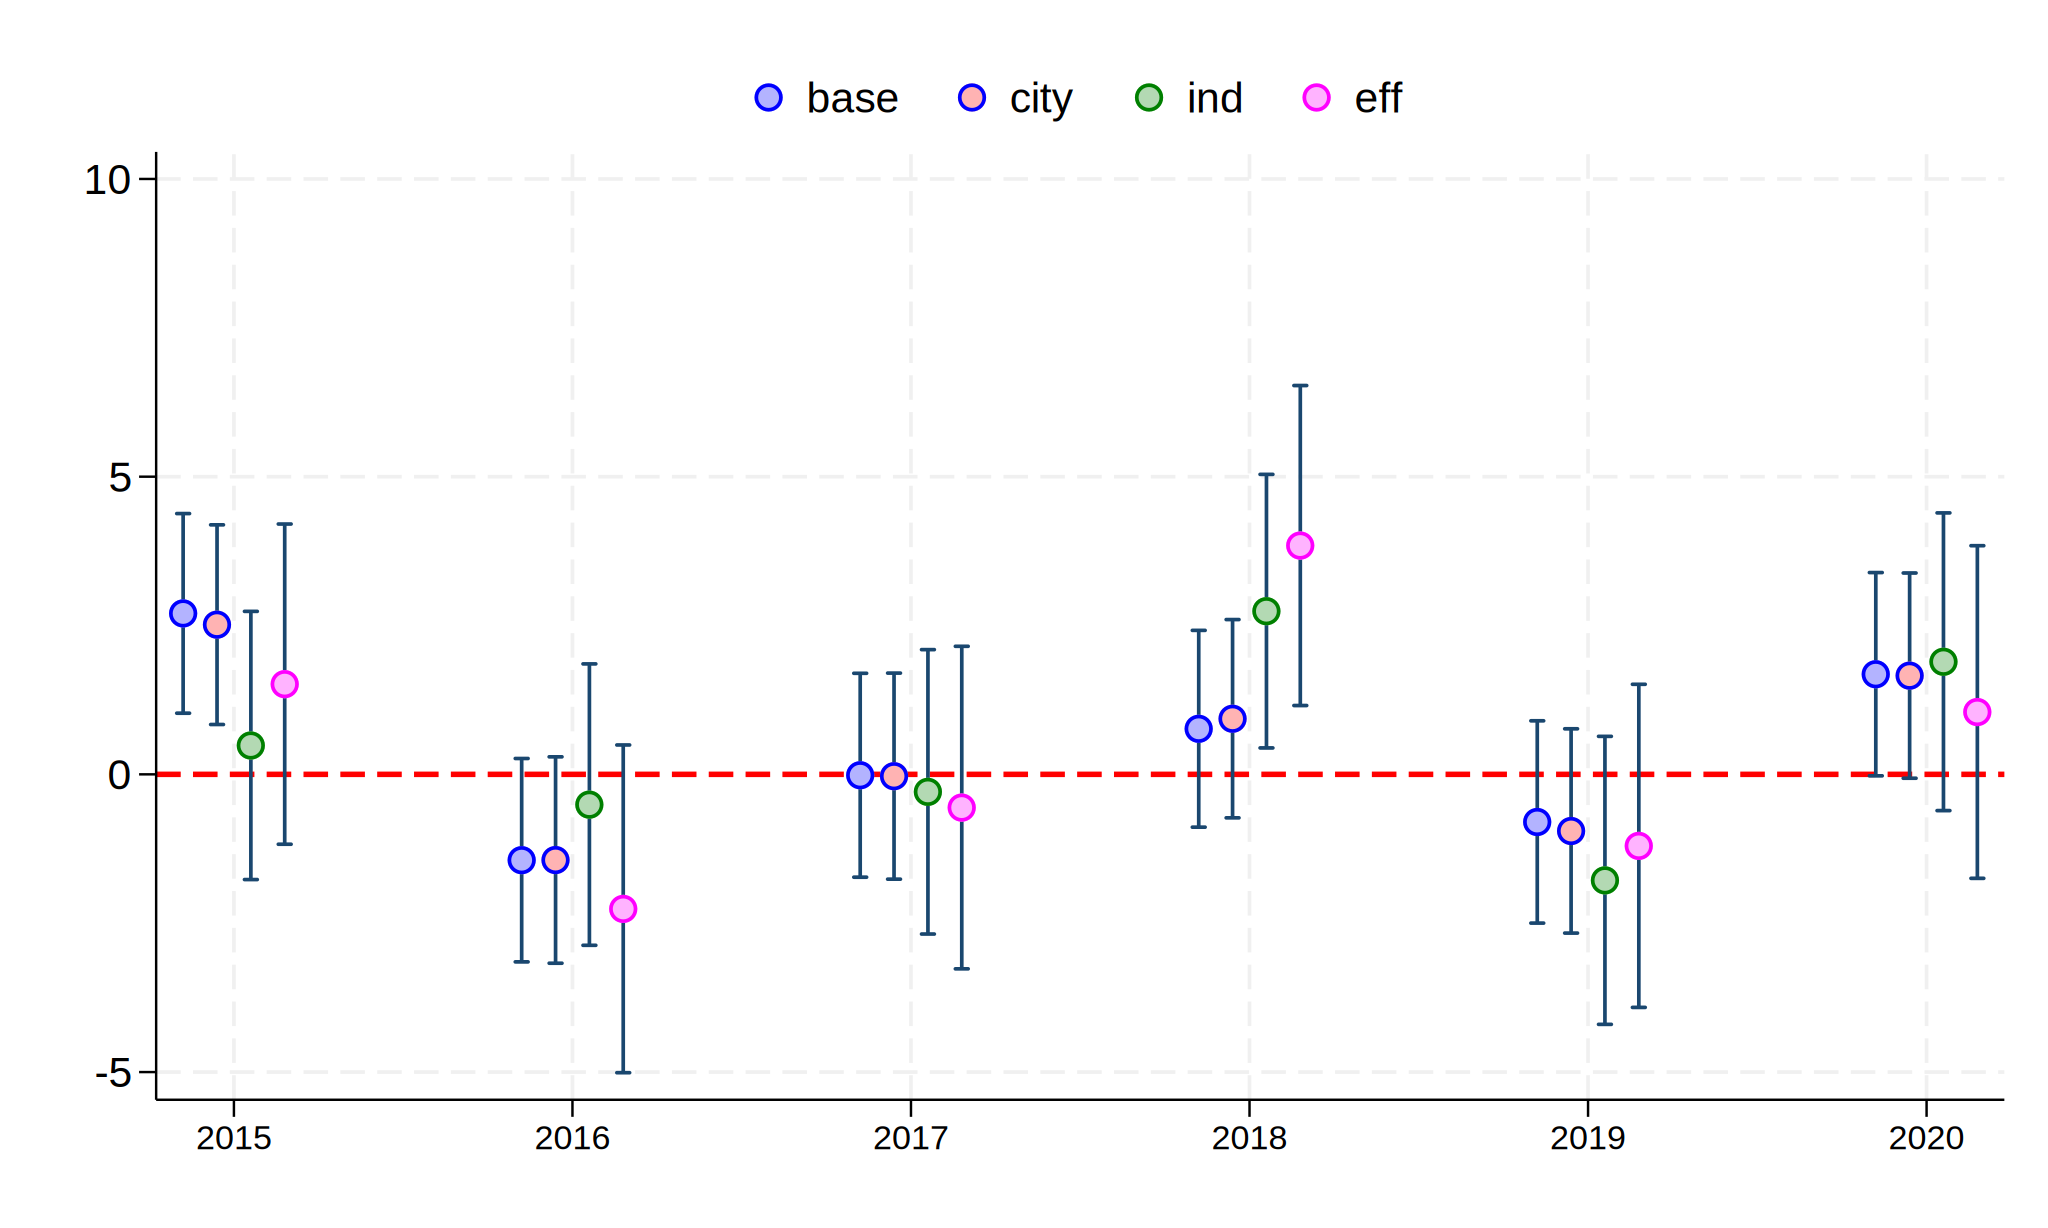

In [66]:
%%stata
#delimit;
qui{;
use suicide_m_reduced.dta,clear;
rename bvl bvl_base;
rename bup bup_base;
rename bdn bdn_base;
gen hoge=1;
merge 1:1 indx using suicide_m_reduced_city.dta;
drop _merge;
rename bvl bvl_city;
rename bup bup_city;
rename bdn bdn_city;
replace hoge=2;
merge 1:1 indx using suicide_m_reduced_ind.dta;
drop _merge;
rename bvl bvl_ind;
rename bup bup_ind;
rename bdn bdn_ind;
replace hoge=3;
merge 1:1 indx using suicide_m_reduced_eff.dta;
drop _merge;
rename bvl bvl_eff;
rename bup bup_eff;
rename bdn bdn_eff;
replace hoge=4;

gen indx1=indx-0.15;
gen indx2=indx-0.05;
gen indx3=indx+0.05;
gen indx4=indx+0.15;

local ylb =" ylabel(-2.5(0.5)6.0) yscale(range(-2.5(0.5)6.0)) ";      
twoway rcap bup_base bdn_base indx1,lcolor(navy)  || scatter bvl_base indx1,msize(2.0) ms(circle)  mlcolor(blue) mfcolor(blue*.3)  ||
rcap bup_city bdn_city indx2,lcolor(navy)  || scatter bvl_city indx2,msize(2.0) ms(circle)  mlcolor(blue) mfcolor(red*.3)  ||
rcap bup_ind bdn_ind indx3,lcolor(navy)  || scatter bvl_ind indx3,msize(2.0) ms(circle)  mlcolor(green) mfcolor(green*.3) || 
rcap bup_eff bdn_eff indx4,lcolor(navy)  || scatter bvl_eff indx4 , msize(2.0) ms(circle)  mlcolor(magenta) mfcolor(magenta*.3)
name("`nmc'`_indx'",replace)  saving("event_graph_m4049_1",replace) legend(off) title("`tt'") `ylab'
xtitle("")  xsc(range(1 `nn')) 
xlabel(0 "2015" 1 "2016" 2 "2017" 3 "2018" 4 "2019" 5 "2020",  labsize(small) angle(0))
legend(on order(2 "base" 4 "city" 6 "ind" 8 "eff") row(1) position(12))
yline(0, lcolor(red) lwidth(medthick));
};


. 
. #delimit;
delimiter now ;
. qui{;

. 


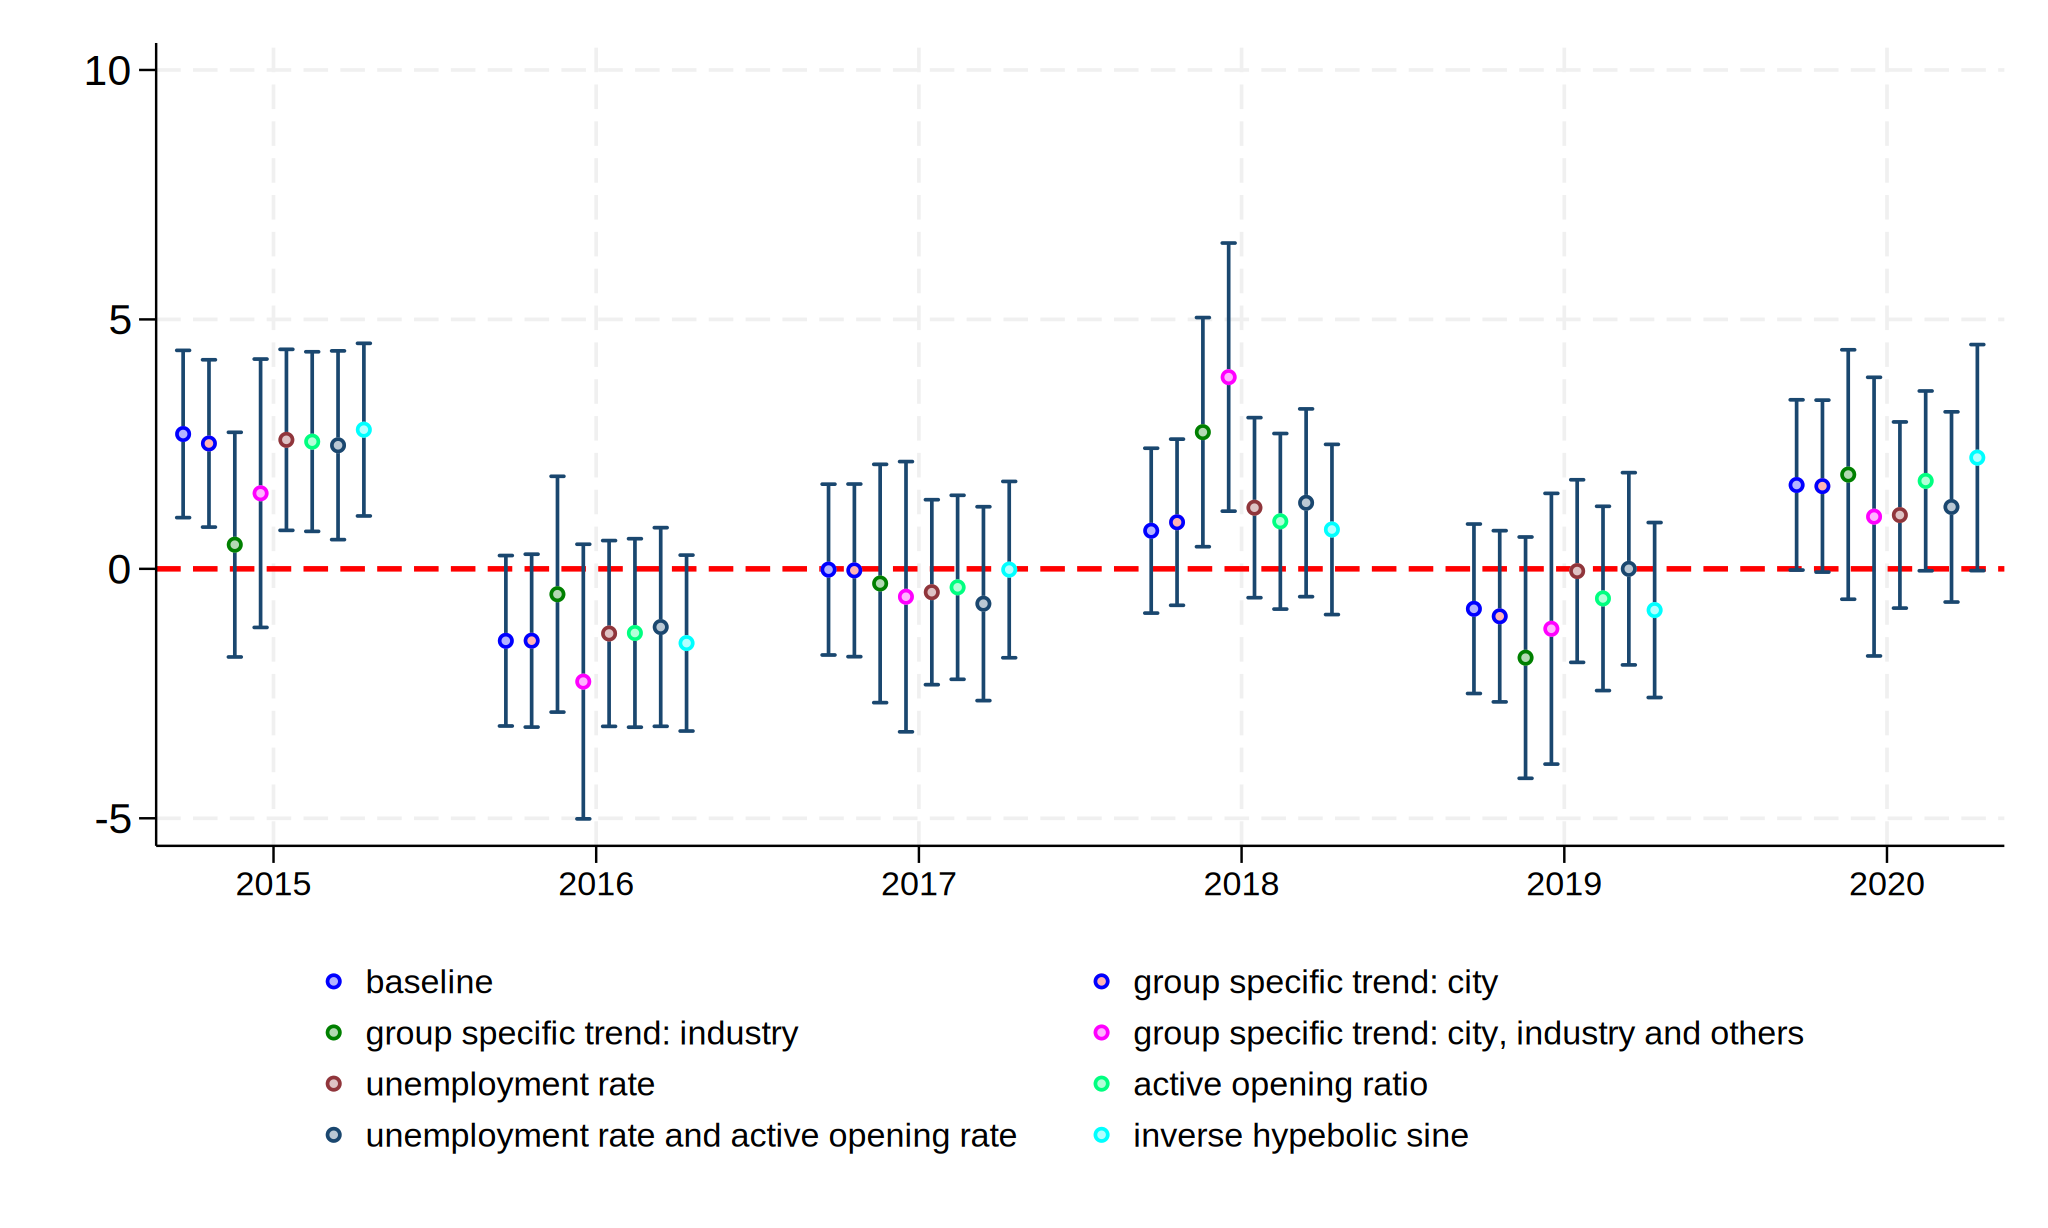

In [67]:
%%stata

#delimit;
qui{;
use suicide_m_reduced.dta,clear;
rename bvl bvl_base;
rename bup bup_base;
rename bdn bdn_base;
gen hoge=1;
merge 1:1 indx using suicide_m_reduced_city.dta;
drop _merge;
rename bvl bvl_city;
rename bup bup_city;
rename bdn bdn_city;
replace hoge=2;
merge 1:1 indx using suicide_m_reduced_ind.dta;
drop _merge;
rename bvl bvl_ind;
rename bup bup_ind;
rename bdn bdn_ind;
replace hoge=3;
merge 1:1 indx using suicide_m_reduced_eff.dta;
drop _merge;
rename bvl bvl_eff;
rename bup bup_eff;
rename bdn bdn_eff;
replace hoge=4;
merge 1:1 indx using suicide_m_reduced_unemp.dta;
drop _merge;
rename bvl bvl_unemp;
rename bup bup_unemp;
rename bdn bdn_unemp;
replace hoge=5;
merge 1:1 indx using suicide_m_reduced_actopn.dta;
drop _merge;
rename bvl bvl_actopn;
rename bup bup_actopn;
rename bdn bdn_actopn;
replace hoge=6;
merge 1:1 indx using suicide_m_reduced_une_act.dta;
drop _merge;
rename bvl bvl_une_act;
rename bup bup_une_act;
rename bdn bdn_une_act;
replace hoge=7;
merge 1:1 indx using suicide_m_reduced_ihs.dta;
drop _merge;
rename bvl bvl_ihs;
rename bup bup_ihs;
rename bdn bdn_ihs;
replace hoge=8;

gen indx1=indx-0.28;
gen indx2=indx-0.20;
gen indx3=indx-0.12;
gen indx4=indx-0.04;
gen indx5=indx+0.04;
gen indx6=indx+0.12;
gen indx7=indx+0.20;
gen indx8=indx+0.28;

local ylb =" ylabel(-2.5(0.5)6.0) yscale(range(-2.5(0.5)6.0)) ";      
twoway rcap bup_base bdn_base indx1,lcolor(navy)  || scatter bvl_base indx1,msize(1.0) ms(circle)  mlcolor(blue) mfcolor(blue*.3)  ||
rcap bup_city bdn_city indx2,lcolor(navy)  || scatter bvl_city indx2,msize(1.0) ms(circle)  mlcolor(blue) mfcolor(red*.3)  ||
rcap bup_ind bdn_ind indx3,lcolor(navy)  || scatter bvl_ind indx3,msize(1.0) ms(circle)  mlcolor(green) mfcolor(green*.3) || 
rcap bup_eff bdn_eff indx4,lcolor(navy)  || scatter bvl_eff indx4 , msize(1.0) ms(circle)  mlcolor(magenta) mfcolor(magenta*.3) ||
rcap bup_unemp bdn_unemp indx5,lcolor(navy)  || scatter bvl_unemp indx5,msize(1.0) ms(circle)  mlcolor(maroon) mfcolor(maroon*.3)  ||
rcap bup_actopn bdn_actopn indx6,lcolor(navy)  || scatter bvl_actopn indx6,msize(1.0) ms(circle)  mlcolor(mint) mfcolor(mint*.3) || 
rcap bup_une_act bdn_une_act indx7,lcolor(navy)  || scatter bvl_une_act indx7 , msize(1.0) ms(circle)  mlcolor(navy) mfcolor(navy*.3) ||
rcap bup_ihs bdn_ihs indx8,lcolor(navy)  || scatter bvl_ihs indx8 , msize(1.0) ms(circle)  mlcolor(cyan) mfcolor(cyan*.3) 
name("`nmc'`_indx'",replace)  saving("event_graph_m4049_2",replace) legend(off) title("`tt'") `ylab'
xtitle("")  xsc(range(1 `nn')) 
xlabel(0 "2015" 1 "2016" 2 "2017" 3 "2018" 4 "2019" 5 "2020",  labsize(small) angle(0))
legend(on order(2 "baseline" 4 "group specific trend: city" 6 "group specific trend: industry" 8 "group specific trend: city, industry and others" 10 "unemployment rate" 12 "active opening ratio" 14 "unemployment rate and active opening rate" 16 "inverse hypebolic sine") row(6) position(6) size(small))
yline(0, lcolor(red) lwidth(medthick));

};


## Male 40-49: commuting_time60_90_iv

In [68]:
%%stata
qui{
capture restore    
use ../data/suicide_analysis_data_static,clear
xtset citycode covid
    
/* Local macro */
local absvars="citycode covid"
local clsvars="citycode"
local absvars_ind "i.citycode i.covid"    
local gmm2="gmm2s"
local log_="log_"
sum suicide
local suicide_t_m=r(mean)
sum suicide_m
local suicide_m_m=r(mean)
sum suicide_f
local suicide_f_m=r(mean)
sum `log_'active_opening_ratio
local log_active_opening_ratio_m=r(mean)
sum `log_'unemployment_rate
local log_unemployment_rate_m=r(mean)
sum `log_'patient
local log_patient_m=r(mean)
sum log_active_opening_weighted
local log_active_opening_weighted_m=r(mean)
sum log_bankruptcy_debt
local log_bankruptcy_debt_m=r(mean)


* bundle commute time IV variable
local commute_time_ratio_ivs = "commuter_ratio_no commuter_ratio_u15 commuter_ratio_15_30 commuter_ratio_30_45 commuter_ratio_45_60 commuter_ratio_60_90 commuter_ratio_90_120 commuter_ratio_o120 "

* For Tables
local txt_u20="Under 20"
local txt_20_29="20-29"
local txt_30_39="30-39"
local txt_40_49="40-49"
local txt_50_59="50-59"
local txt_o60="60 or over"

/* Transformation of log(1+var) */
local paracomp_ct_1st="(commuting_time60_90_iv: _b[D1.commuting_time_iv])  "

local paracomp_f_stayhome="(stay_home: _b[D.stay_home]*(1+`suicide_f_m')/(`suicide_f_m')) "
local paracomp_f_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_f_m')/(`suicide_f_m'))  "
local paracomp_f_ct_reduced="(commuting_time60_90_iv: _b[commuting_time60_90_iv]*(1+`suicide_f_m')/(`suicide_f_m'))  "

local paracomp_m_stayhome="(stay_home: _b[D.stay_home]*(1+`suicide_m_m')/(`suicide_m_m')) "
local paracomp_m_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_m_m')/(`suicide_m_m'))  "
local paracomp_m_ct_reduced="(commuting_time60_90_iv_iv: _b[commuting_time60_90_iv]*(1+`suicide_m_m')/(`suicide_m_m'))  "
}


. qui{

. 


In [69]:
%%stata
qui{
sum suicide_m_40_49
local suicide_m_m=r(mean)
local paracomp_m_cr_reduced="(commuter_ratio: _b[commuter_ratio]*(1+`suicide_m_m')/(`suicide_m_m'))  "
save temp,replace    
}


. qui{

. 


In [70]:
%%stata
qui{
use temp,replace   
reghdfe D.suicide_m_40_49_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced0
preserve
}


. qui{

. 


In [71]:
%%stata
qui{
capture restore    
use temp,clear
preserve
use ../data/suicide_analysis_data,clear

collapse (sum) suicide_m_40_49 (first) prefecture cityname,by(citycode year)
rename suicide_m_40_49 suicide_m_40_49_
reshape wide suicide_m_40_49, i(citycode)  j(year)
save suicide_m_40_49_past,replace
restore
merge m:1 citycode using suicide_m_40_49_past,keepusing(suicide_m_40_49_*)
drop _merge

gen suicide_m_40_49_14_log=log(1+suicide_m_40_49_2014)
gen suicide_m_40_49_15_log=log(1+suicide_m_40_49_2015)
gen suicide_m_40_49_16_log=log(1+suicide_m_40_49_2016)
gen suicide_m_40_49_17_log=log(1+suicide_m_40_49_2017)
gen suicide_m_40_49_18_log=log(1+suicide_m_40_49_2018)
gen suicide_m_40_49_19_log=log(1+suicide_m_40_49_2019)

gen D1_suicide_m_40_49_log=suicide_m_40_49_19_log-suicide_m_40_49_18_log
gen D2_suicide_m_40_49_log=suicide_m_40_49_18_log-suicide_m_40_49_17_log
gen D3_suicide_m_40_49_log=suicide_m_40_49_17_log-suicide_m_40_49_16_log
gen D4_suicide_m_40_49_log=suicide_m_40_49_16_log-suicide_m_40_49_15_log
gen D5_suicide_m_40_49_log=suicide_m_40_49_15_log-suicide_m_40_49_14_log
   
local clsvars="citycode"
xtset citycode covid
             


reghdfe D.suicide_m_40_49_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_40_49reduced0

reghdfe  D1_suicide_m_40_49_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1
reghdfe  D2_suicide_m_40_49_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2
reghdfe  D3_suicide_m_40_49_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3
reghdfe  D4_suicide_m_40_49_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4
reghdfe  D5_suicide_m_40_49_log commuting_time60_90_iv, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5
                                                        
coefplot suicide_m_reduced5 ,bylabel(2015)|| suicide_m_reduced4 ,bylabel(2016) || suicide_m_reduced3  ,bylabel(2017)  || suicide_m_reduced2  ,bylabel(2018)  || suicide_m_reduced1  ,bylabel(2019)  || suicide_m_reduced0 , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw
                                                           
preserve
}                                                     


. qui{

. 


In [72]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t';
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


### WITH CONTROL

In [73]:
%%stata 
qui{
global city_ind_large_eff_lev_controls "is_city industry_large_1_15 industry_large_2_15 industry_large_3_15 young_rate self_employee_rate labor_force_rate single_household_ratio "
}


. qui{

. 


In [74]:
%%stata
qui{
restore
reghdfe D.suicide_m_40_49_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced0_city

reghdfe  D1_suicide_m_40_49_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1_city
reghdfe  D2_suicide_m_40_49_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2_city
reghdfe  D3_suicide_m_40_49_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3_city
reghdfe  D4_suicide_m_40_49_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4_city
reghdfe  D5_suicide_m_40_49_log commuting_time60_90_iv is_city, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5_city

coefplot suicide_m_reduced5_city ,bylabel(2015)|| suicide_m_reduced4_city ,bylabel(2016) || suicide_m_reduced3_city  ,bylabel(2017)  || suicide_m_reduced2_city  ,bylabel(2018)  || suicide_m_reduced1_city  ,bylabel(2019)  || suicide_m_reduced0_city , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw
preserve 

}


. qui{

. 


In [75]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_city;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_city.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [76]:
%%stata
qui{
restore
reghdfe D.suicide_m_40_49_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced0_ind

reghdfe  D1_suicide_m_40_49_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced1_ind
reghdfe  D2_suicide_m_40_49_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced2_ind
reghdfe  D3_suicide_m_40_49_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced3_ind
reghdfe  D4_suicide_m_40_49_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced4_ind
reghdfe  D5_suicide_m_40_49_log commuting_time60_90_iv industry_large_1_15 industry_large_2_15, cluster(`clsvars') noabsorb
nlcom `paracomp_f_ct_reduced', post
est store suicide_m_reduced5_ind

coefplot suicide_m_reduced5_ind ,bylabel(2015)|| suicide_m_reduced4_ind ,bylabel(2016) || suicide_m_reduced3_ind  ,bylabel(2017)  || suicide_m_reduced2_ind  ,bylabel(2018)  || suicide_m_reduced1_ind  ,bylabel(2019)  || suicide_m_reduced0_ind , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw
preserve
}


. qui{

. 


In [77]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_ind;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_ind.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [78]:
%%stata
qui{
restore
reghdfe D.suicide_m_40_49_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced0_eff

reghdfe  D1_suicide_m_40_49_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1_eff
reghdfe  D2_suicide_m_40_49_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2_eff
reghdfe  D3_suicide_m_40_49_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3_eff
reghdfe  D4_suicide_m_40_49_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4_eff
reghdfe  D5_suicide_m_40_49_log commuting_time60_90_iv $city_ind_large_eff_lev_controls, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5_eff

coefplot suicide_m_reduced5_eff ,bylabel(2015)|| suicide_m_reduced4_eff ,bylabel(2016) || suicide_m_reduced3_eff  ,bylabel(2017)  || suicide_m_reduced2_eff  ,bylabel(2018)  || suicide_m_reduced1_eff  ,bylabel(2019)  || suicide_m_reduced0_eff , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [79]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_eff;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_eff.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [80]:
%%stata
qui{
capture restore
reghdfe D.suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced0_unemp

reghdfe  D1_suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1_unemp
reghdfe  D2_suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2_unemp
reghdfe  D3_suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3_unemp
reghdfe  D4_suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4_unemp
reghdfe  D5_suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5_unemp

coefplot suicide_m_reduced5_unemp ,bylabel(2015)|| suicide_m_reduced4_unemp ,bylabel(2016) || suicide_m_reduced3_unemp  ,bylabel(2017)  || suicide_m_reduced2_unemp  ,bylabel(2018)  || suicide_m_reduced1_unemp  ,bylabel(2019)  || suicide_m_reduced0_unemp , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [81]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_unemp;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_unemp.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [82]:
%%stata
qui{
restore
reghdfe D.suicide_m_40_49_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced0_actopn

reghdfe  D1_suicide_m_40_49_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1_actopn
reghdfe  D2_suicide_m_40_49_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2_actopn
reghdfe  D3_suicide_m_40_49_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3_actopn
reghdfe  D4_suicide_m_40_49_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4_actopn
reghdfe  D5_suicide_m_40_49_log commuting_time60_90_iv D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5_actopn

coefplot suicide_m_reduced5_actopn ,bylabel(2015)|| suicide_m_reduced4_actopn ,bylabel(2016) || suicide_m_reduced3_actopn  ,bylabel(2017)  || suicide_m_reduced2_actopn  ,bylabel(2018)  || suicide_m_reduced1_actopn  ,bylabel(2019)  || suicide_m_reduced0_actopn , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [83]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_actopn;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_actopn.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [84]:
%%stata
qui{
capture restore
reghdfe D.suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store  suicide_m_reduced0_une_act

reghdfe  D1_suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced1_une_act
reghdfe  D2_suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced2_une_act
reghdfe  D3_suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced3_une_act
reghdfe  D4_suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced4_une_act
reghdfe  D5_suicide_m_40_49_log commuting_time60_90_iv D.log_unemployment_rate D.log_active_opening_ratio, cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_reduced', post
est store suicide_m_reduced5_une_act

coefplot suicide_m_reduced5_une_act ,bylabel(2015)|| suicide_m_reduced4_une_act ,bylabel(2016) || suicide_m_reduced3_une_act  ,bylabel(2017)  || suicide_m_reduced2_une_act  ,bylabel(2018)  || suicide_m_reduced1_une_act  ,bylabel(2019)  || suicide_m_reduced0_une_act , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [85]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_une_act;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_une_act.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


In [86]:
%%stata
qui{
local paracomp_m_ct_ihs_reduced="(commuting_time60_90_iv: _b[commuting_time60_90_iv]*((sqrt(`suicide_m_m'^2+1))/`suicide_m_m')) "

capture restore

reghdfe D.suicide_m_40_49_ihs commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced0_ihs

reghdfe  D1_suicide_m_40_49_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced1_ihs
reghdfe  D2_suicide_m_40_49_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced2_ihs
reghdfe  D3_suicide_m_40_49_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced3_ihs
reghdfe  D4_suicide_m_40_49_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced4_ihs
reghdfe  D5_suicide_m_40_49_log commuting_time60_90_iv , cluster(`clsvars') noabsorb
nlcom `paracomp_m_ct_ihs_reduced', post
est store suicide_m_reduced5_ihs

coefplot suicide_m_reduced5_ihs ,bylabel(2015)|| suicide_m_reduced4_ihs ,bylabel(2016) || suicide_m_reduced3_ihs  ,bylabel(2017)  || suicide_m_reduced2_ihs  ,bylabel(2018)  || suicide_m_reduced1_ihs  ,bylabel(2019)  || suicide_m_reduced0_ihs , graphregion(color(white)) bylabel(base) bycoefs drop(_cons) vertical ytitle( Coefficient ) mcolor(navy)ciopts(recast(rcap) lcolor(navy) lwidth(*2))  label("Commuting-time shift-share IV") yline(0, lcolor(midblue) lpattern(dash)) name(pre_test,replace) saving(pre_test,replace) nodraw

preserve
}


. qui{

. 


In [87]:
%%stata
#delimit;
qui{;
foreach t of numlist 5/0{;
tempfile box`t';
est restore  suicide_m_reduced`t'_ihs;
matrix b=e(b);
matrix b=b';
mata st_matrix("s",sqrt(diagonal(st_matrix("e(V)"))));
matrix bvl=b;
matrix bup=b+1.96*s;
matrix bdn=b-1.96*s;
local names : rownames b;
matrix rownames bup = `names';
matrix rownames bdn = `names';
xsvmat bvl, names("bvl") rowname(b)  saving(bvl, replace);
xsvmat bup, names("bup") rowname(bup) saving(bup, replace); 
xsvmat bdn, names("bdn") rowname(bdn) saving(bdn, replace);
use bvl,clear;
rename b bup;
merge 1:1 bup using bup; drop _merge;
rename bup bdn;
merge 1:1 bdn using bdn; drop _merge;
rename bdn kd;
reshape long bvl bup bdn, i(kd) j(indx);
replace indx =5-`t';
save box`t',replace;
};
use box0,clear;
foreach t of numlist 1/5{;
append using box`t';
erase box`t'.dta;
};
sort indx;
save suicide_m_reduced_ihs.dta,replace ;
erase bvl.dta;
erase bdn.dta;
erase bup.dta;
};


. #delimit;
delimiter now ;
. qui{;

. 


### Combine Graphs: commuting_time_iv


. #delimit;
delimiter now ;
. qui{;

. 


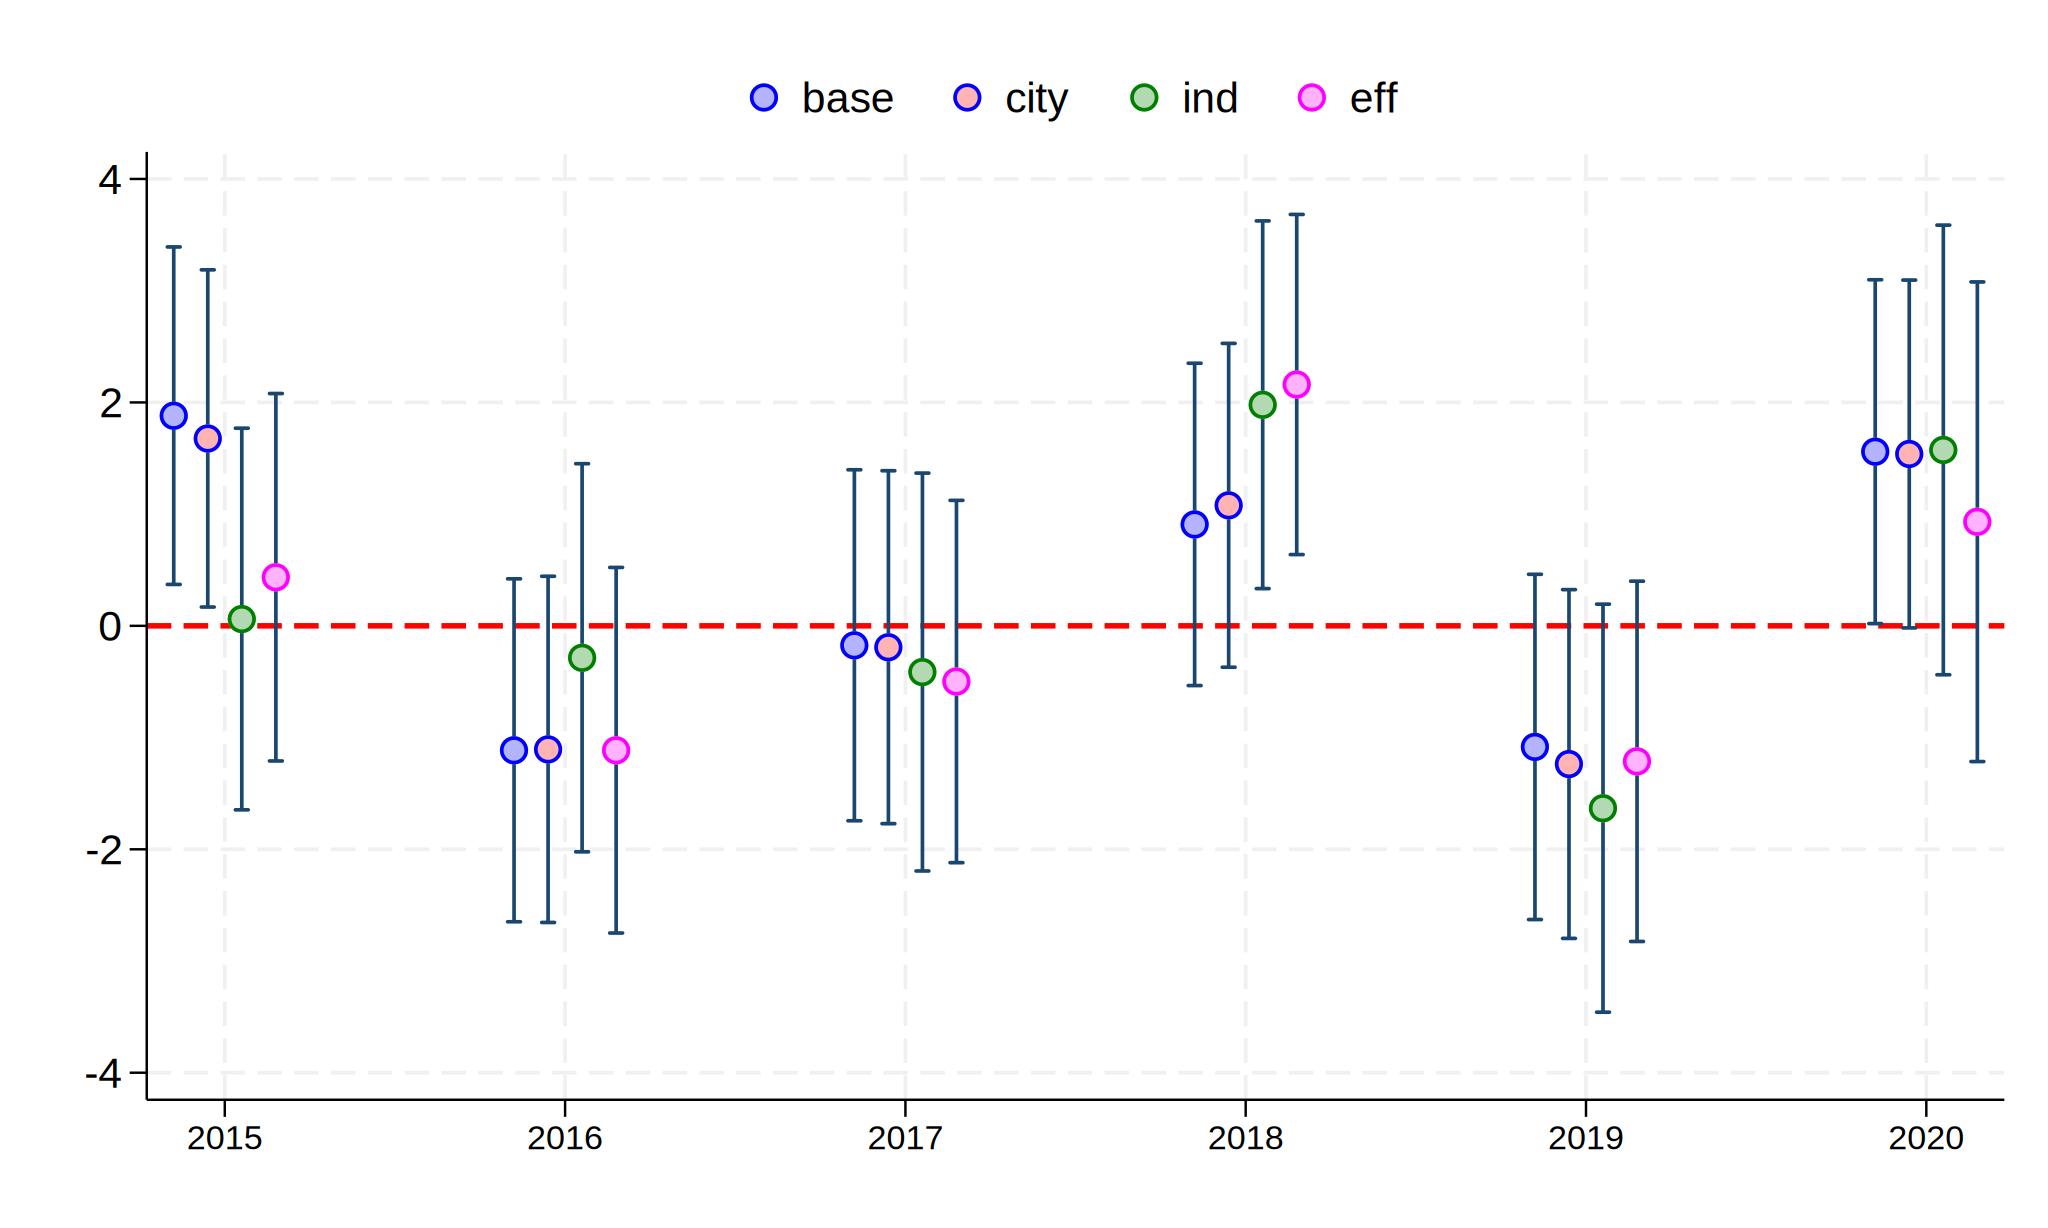

In [88]:
%%stata
#delimit;
qui{;
use suicide_m_reduced.dta,clear;
rename bvl bvl_base;
rename bup bup_base;
rename bdn bdn_base;
gen hoge=1;
merge 1:1 indx using suicide_m_reduced_city.dta;
drop _merge;
rename bvl bvl_city;
rename bup bup_city;
rename bdn bdn_city;
replace hoge=2;
merge 1:1 indx using suicide_m_reduced_ind.dta;
drop _merge;
rename bvl bvl_ind;
rename bup bup_ind;
rename bdn bdn_ind;
replace hoge=3;
merge 1:1 indx using suicide_m_reduced_eff.dta;
drop _merge;
rename bvl bvl_eff;
rename bup bup_eff;
rename bdn bdn_eff;
replace hoge=4;

gen indx1=indx-0.15;
gen indx2=indx-0.05;
gen indx3=indx+0.05;
gen indx4=indx+0.15;

local ylb =" ylabel(-2.5(0.5)6.0) yscale(range(-2.5(0.5)6.0)) ";      
twoway rcap bup_base bdn_base indx1,lcolor(navy)  || scatter bvl_base indx1,msize(2.0) ms(circle)  mlcolor(blue) mfcolor(blue*.3)  ||
rcap bup_city bdn_city indx2,lcolor(navy)  || scatter bvl_city indx2,msize(2.0) ms(circle)  mlcolor(blue) mfcolor(red*.3)  ||
rcap bup_ind bdn_ind indx3,lcolor(navy)  || scatter bvl_ind indx3,msize(2.0) ms(circle)  mlcolor(green) mfcolor(green*.3) || 
rcap bup_eff bdn_eff indx4,lcolor(navy)  || scatter bvl_eff indx4 , msize(2.0) ms(circle)  mlcolor(magenta) mfcolor(magenta*.3)
name("`nmc'`_indx'",replace)  saving("event_graph_m4049_1_single_iv",replace) legend(off) title("`tt'") `ylab'
xtitle("")  xsc(range(1 `nn')) 
xlabel(0 "2015" 1 "2016" 2 "2017" 3 "2018" 4 "2019" 5 "2020",  labsize(small) angle(0))
legend(on order(2 "base" 4 "city" 6 "ind" 8 "eff") row(1) position(12))
yline(0, lcolor(red) lwidth(medthick));
graph export "pretrend_stayhome_commuting_time_60_90_iv_m40_49.jpg", as(jpg) width(4000) height(2500) quality(100) replace;
};


. 
. #delimit;
delimiter now ;
. qui{;

. 


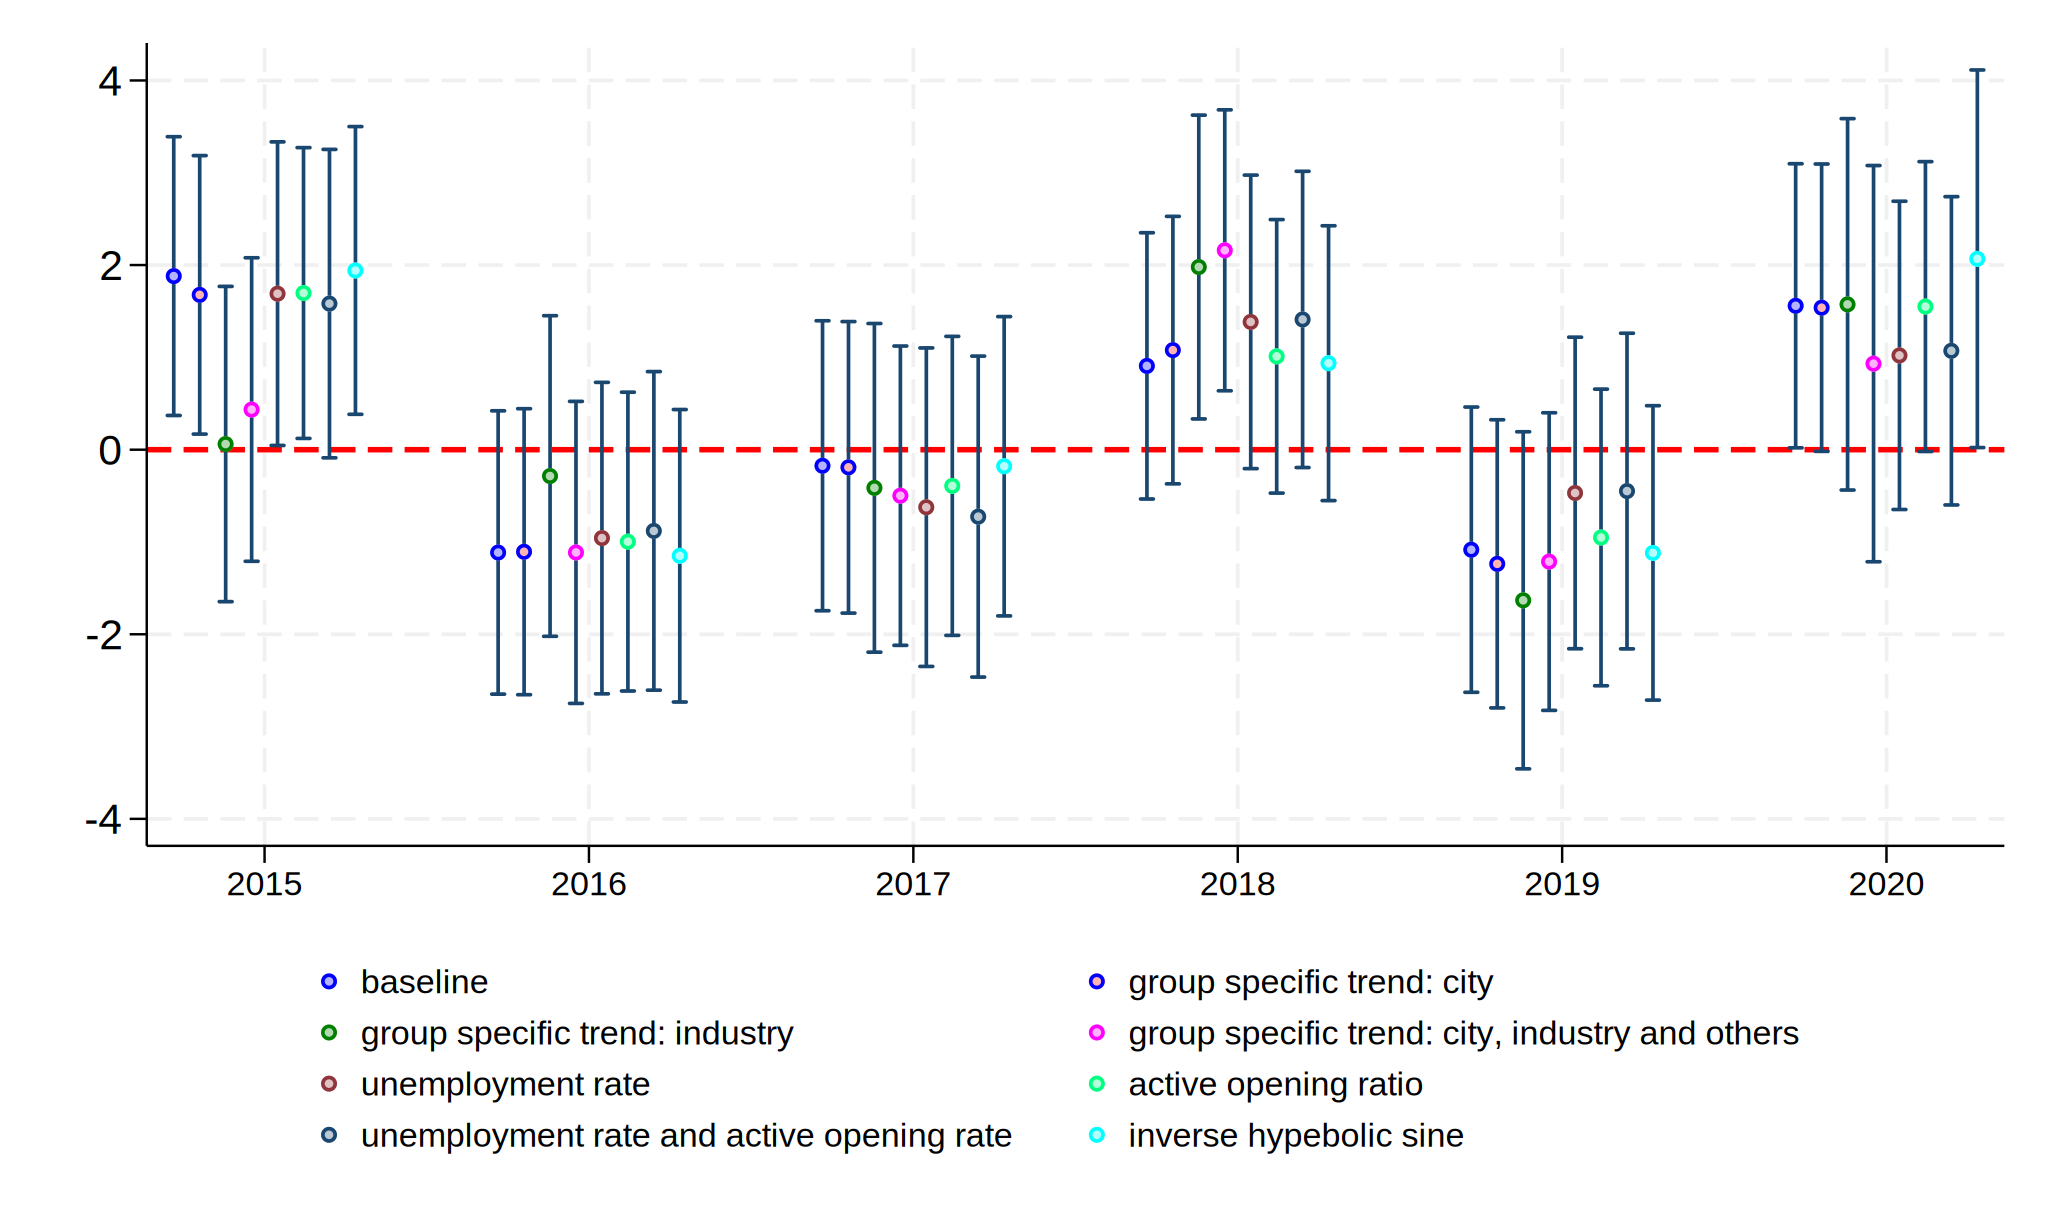

In [89]:
%%stata

#delimit;
qui{;
use suicide_m_reduced.dta,clear;
rename bvl bvl_base;
rename bup bup_base;
rename bdn bdn_base;
gen hoge=1;
merge 1:1 indx using suicide_m_reduced_city.dta;
drop _merge;
rename bvl bvl_city;
rename bup bup_city;
rename bdn bdn_city;
replace hoge=2;
merge 1:1 indx using suicide_m_reduced_ind.dta;
drop _merge;
rename bvl bvl_ind;
rename bup bup_ind;
rename bdn bdn_ind;
replace hoge=3;
merge 1:1 indx using suicide_m_reduced_eff.dta;
drop _merge;
rename bvl bvl_eff;
rename bup bup_eff;
rename bdn bdn_eff;
replace hoge=4;
merge 1:1 indx using suicide_m_reduced_unemp.dta;
drop _merge;
rename bvl bvl_unemp;
rename bup bup_unemp;
rename bdn bdn_unemp;
replace hoge=5;
merge 1:1 indx using suicide_m_reduced_actopn.dta;
drop _merge;
rename bvl bvl_actopn;
rename bup bup_actopn;
rename bdn bdn_actopn;
replace hoge=6;
merge 1:1 indx using suicide_m_reduced_une_act.dta;
drop _merge;
rename bvl bvl_une_act;
rename bup bup_une_act;
rename bdn bdn_une_act;
replace hoge=7;
merge 1:1 indx using suicide_m_reduced_ihs.dta;
drop _merge;
rename bvl bvl_ihs;
rename bup bup_ihs;
rename bdn bdn_ihs;
replace hoge=8;

gen indx1=indx-0.28;
gen indx2=indx-0.20;
gen indx3=indx-0.12;
gen indx4=indx-0.04;
gen indx5=indx+0.04;
gen indx6=indx+0.12;
gen indx7=indx+0.20;
gen indx8=indx+0.28;

local ylb =" ylabel(-2.5(0.5)6.0) yscale(range(-2.5(0.5)6.0)) ";      
twoway rcap bup_base bdn_base indx1,lcolor(navy)  || scatter bvl_base indx1,msize(1.0) ms(circle)  mlcolor(blue) mfcolor(blue*.3)  ||
rcap bup_city bdn_city indx2,lcolor(navy)  || scatter bvl_city indx2,msize(1.0) ms(circle)  mlcolor(blue) mfcolor(red*.3)  ||
rcap bup_ind bdn_ind indx3,lcolor(navy)  || scatter bvl_ind indx3,msize(1.0) ms(circle)  mlcolor(green) mfcolor(green*.3) || 
rcap bup_eff bdn_eff indx4,lcolor(navy)  || scatter bvl_eff indx4 , msize(1.0) ms(circle)  mlcolor(magenta) mfcolor(magenta*.3) ||
rcap bup_unemp bdn_unemp indx5,lcolor(navy)  || scatter bvl_unemp indx5,msize(1.0) ms(circle)  mlcolor(maroon) mfcolor(maroon*.3)  ||
rcap bup_actopn bdn_actopn indx6,lcolor(navy)  || scatter bvl_actopn indx6,msize(1.0) ms(circle)  mlcolor(mint) mfcolor(mint*.3) || 
rcap bup_une_act bdn_une_act indx7,lcolor(navy)  || scatter bvl_une_act indx7 , msize(1.0) ms(circle)  mlcolor(navy) mfcolor(navy*.3) ||
rcap bup_ihs bdn_ihs indx8,lcolor(navy)  || scatter bvl_ihs indx8 , msize(1.0) ms(circle)  mlcolor(cyan) mfcolor(cyan*.3) 
name("`nmc'`_indx'",replace)  saving("event_graph_m4049_2_single_iv",replace) legend(off) title("`tt'") `ylab'
xtitle("")  xsc(range(1 `nn')) 
xlabel(0 "2015" 1 "2016" 2 "2017" 3 "2018" 4 "2019" 5 "2020",  labsize(small) angle(0))
legend(on order(2 "baseline" 4 "group specific trend: city" 6 "group specific trend: industry" 8 "group specific trend: city, industry and others" 10 "unemployment rate" 12 "active opening ratio" 14 "unemployment rate and active opening rate" 16 "inverse hypebolic sine") row(6) position(6) size(small))
yline(0, lcolor(red) lwidth(medthick));

};


# Specification Curve

## Female

### Make Data

In [ ]:
%%stata 
qui{
capture restore
use ../data/suicide_analysis_data,clear    
keep if year==2019|year==2020|year==2021
drop if (year==2019 & month<=3) | (year==2021 & month>=4)

/* mobility adjustment */
replace mobility=0 if mobility<0 & mobility~=.
replace stay_home=1 if stay_home>1 & stay_home~=.

save temp0,replace
drop if (year==2020 & month==3)
save temp1,replace    
drop if (year==2020 & month==3)|(year==2021 & month==3)
save temp2,replace    

foreach t of numlist 0/2{
use temp`t',clear
    
collapse (sum) suicide* (mean) stay_home mobility *_ratio* unemployment_rate patient covid_death_cases prefcode (first) prefecture cityname is_city, by(citycode covid)

    
/* Rename mobility index */
rename mobility mobility_index


local x "u20" 
gen suicide_f_`x'_log=log(1+suicide_f_`x')
gen suicide_`x'_log=log(1+suicide_`x')
gen suicide_f_`x'_ihs=asinh(suicide_f_`x')
gen suicide_`x'_ihs=asinh(suicide_`x')

/* Make time-varying covariates */
gen log_active_opening_ratio=log(active_opening_ratio)
gen log_unemployment_rate=log(unemployment_rate)
gen log_patient = log(1+patient)
gen log_covid_death_cases =log(1+covid_death_cases)

/* Make pre-covid (time-invariant) covariates */

* rename 2015 census variables
forvalues i = 1/38 {
    rename g`i'_ratio g`i'_ratio_15
}
    
* make industry share column
local i=1
foreach x of numlist 6 8/26 {
local a=char(96+`i')
gen industry_`a' = .
gen industry_`a'_15 = .
gen industry_`a'_20 = .
replace industry_`a' = g`x'_ratio_15 if covid == 0
replace industry_`a' = g`x'_ratio_20 if covid == 1
replace industry_`a'_15 = g`x'_ratio_15
replace industry_`a'_20 = g`x'_ratio_20
local i=`i'+1
}

* make indsutry share in large category    
foreach str in "" "_15" "_20" {             
gen industry_large_1`str' = industry_a`str' + industry_b`str' + industry_c`str'
gen industry_large_2`str' = industry_d`str' + industry_e`str' + industry_f`str'
gen industry_large_3`str' = industry_g`str' + industry_h`str' + industry_i`str' + industry_j`str' + industry_k`str' + industry_l`str' + industry_m`str' + industry_n`str' + industry_o`str' + industry_p`str' + industry_q`str' + industry_r`str' + industry_s`str' + industry_t`str'
}

* make population generations   
gen young_rate=a1_ratio+a2_ratio+a3_ratio 
gen middle_rate=a4_ratio+a5_ratio+a6_ratio+a7_ratio+a8_ratio+a9_ratio+a10_ratio+a11_ratio+a12_ratio+a13_ratio 
gen elderly_rate=a14_ratio+a15_ratio+a16_ratio+a17_ratio+a18_ratio+a19_ratio+a20_ratio+a21_ratio
             
* make other variables
gen employment_rate=j1_ratio 
gen employee_rate=g3_ratio_15
gen self_employee_rate=g4_ratio_15    
gen labor_force_rate=g1_ratio_15
gen single_household_ratio=c4_ratio 

/* Label variables for table making */
label variable stay_home "Stay-at-home index"
label variable mobility_index "Outflow ratio"
            
label variable log_active_opening_ratio "Log(Active job opening ratio)"
label variable log_unemployment_rate "Log(Unemployment rate)"
label variable log_patient "Log(Number of COVID patients)"
label variable log_covid_death_cases "Log(Number of COVID death cases)"

/* Label covariate variables */
label variable young_rate "Young rate"
label variable middle_rate "Middle rate"
label variable elderly_rate "Elderly rate"
label variable employment_rate "Employment rate"
label variable employee_rate "Employee rate"
label variable self_employee_rate "Self-employment rate"
label variable labor_force_rate "Labor force rate"
label variable labor_force_rate "Labor force rate"
label variable single_household_ratio "Single person household rate" 
label variable industry_large_1_15 "Primary industry"
label variable industry_large_2_15 "Secondary industry"
label variable industry_large_3_15 "Tertiary industry"

/* Merge telework data */
preserve             
use ../data/suicide_analysis_data_static,clear
local nrows = _N
use ../data/telework.dta, clear
expand `nrows' // The analysis sample size
gen key = _n
save ../data/telework_merge.dta, replace
restore
             
gen key = _n
merge 1:1 key using  ../data/telework_merge.dta
drop _merge key
             
/* Make commuting-time shift-share IV */
gen commuting_time_iv=commuter_ratio_time00*telework_ratio_time00_bc+commuter_ratio_time30u*telework_ratio_time30u_bc+commuter_ratio_time30_60*telework_ratio_time30_60_bc+commuter_ratio_time60_90*telework_ratio_time60_90_bc+commuter_ratio_time90_120*telework_ratio_time90_120_bc+commuter_ratio_time120o*telework_ratio_time120o_bc if covid==0
replace commuting_time_iv=commuter_ratio_time00*telework_ratio_time00_ac+commuter_ratio_time30u*telework_ratio_time30u_ac+commuter_ratio_time30_60*telework_ratio_time30_60_ac+commuter_ratio_time60_90*telework_ratio_time60_90_ac+commuter_ratio_time90_120*telework_ratio_time90_120_ac+commuter_ratio_time120o*telework_ratio_time120o_ac if covid==1

gen commuting_time30_60_iv = commuter_ratio_time30_60*telework_ratio_time30_60_bc if covid == 0
replace commuting_time30_60_iv = commuter_ratio_time30_60*telework_ratio_time30_60_ac if covid == 1     
    
gen commuting_time60_90_iv = commuter_ratio_time60_90*telework_ratio_time60_90_bc if covid == 0
replace commuting_time60_90_iv = commuter_ratio_time60_90*telework_ratio_time60_90_ac if covid == 1 

sort citycode covid                                                                                                                                                                            
xtset citycode covid
    
gen D_commuting_time_iv = D.commuting_time_iv
gen D_commuting_time30_60_iv = D.commuting_time30_60_iv  
gen D_commuting_time60_90_iv = D.commuting_time60_90_iv   
    
save ../data/data`t'.dta,replace   
erase temp`t'.dta    
}           
}


. qui{


### Loop Execution

### include Patient and Death Cases

In [ ]:
%%stata
qui {
    use ../data/suicide_analysis_data_static, clear

    local x = "u20"
    sum suicide_f_`x'
    local suicide_f_m = r(mean)
    est clear
    local no = 0
    local sig = 0
    local non_sig = 0
    local paracomp_f_stayhome = "(stay_home: _b[D.stay_home]*(1+`suicide_f_m')/(`suicide_f_m'))"

    foreach outcome of numlist 0/1 {
        if `outcome' == 0 {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_f_`x'_log (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death' `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]

                                                            if `no' == 0 {
                                                                noi: di "base: `coef'"
                                                            }

                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
        else {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_f_`x'_ihs (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death'  `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]

                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'
                                                                qui: estadd scalar ihs_v = 1, replace

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }


    noi di "======================="
    local sig_per=`sig'/`no'*100
    local non_sig_per=`non_sig'/`no'*100
    noi di "Significant : `sig' (`sig_per'%)"
    noi di "Non-significant : `non_sig' (`non_sig_per'%)"
}


In [ ]:
%%stata 
speccurve_adj using models,  param(stay_home)  main(md0, graphopts(msize(medium) msymbol(O)) )  graphopts(saving("spec_curve_female_u20_incl_death", replace) )

### Calculate Quantile

In [ ]:
%%stata
* 一時ファイルを用意
tempfile coefs
postfile handle double coef using "`coefs'", replace

* モデル数（ここでは 12288）をループ
forvalues i = 1/12288 {
    estimates use models, number(`i')
    
    * 対象の係数（ここでは stay_home）を取り出す
    * 必要に応じて名前を確認：matrix list e(b)
    quietly post handle (_b[stay_home])
}

postclose handle

* 一時ファイルを開いて分析
use "`coefs'", clear
sort coef
* 任意の分位点を表示（10% 刻み）
centile coef, centile(10(10)90)

* Quintile（5分位）を計算し、最初の5行を表示
pctile pct = coef, nq(5)
list  pct in 1/4

save coefs.dta, replace

### bottom 50

In [ ]:
%%stata
qui {
    use ../data/suicide_analysis_data_static, clear

    local x = "u20"
    sum suicide_f_`x'
    local suicide_f_m = r(mean)
    est clear
    local no = 0
    local sig = 0
    local non_sig = 0
    local paracomp_f_stayhome = "(stay_home: _b[D.stay_home]*(1+`suicide_f_m')/(`suicide_f_m'))"

    foreach outcome of numlist 0/1 {
        if `outcome' == 0 {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_f_`x'_log (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death' `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]



                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef' < 2.9645743{
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_btm50, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_btm50, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
        else {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_f_`x'_ihs (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death'  `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]

                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef' < 2.9645743{
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'
                                                                qui: estadd scalar ihs_v = 1, replace

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_btm50, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_btm50, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }

    noi di `no'

}

In [ ]:
%%stata 
speccurve_adj using models_btm50,  param(stay_home) panel(ihs_v base_period_v alt1_period_v alt2_period_v act_open_rate_v unemp_rate_v city_v indust_v young_rate_v self_employee_rate_v labor_force_rate_v single_household_ratio_v base_iv_v altn_iv_v, labels(inverse_hyperbolic baseline_period alternative_period1 alternative_period2 active_opening_ratio unemployment_rate city_dummy industry_dummies young_rate self_employment_rate labor_force_rate single_household_rate baseline_iv alternative_iv))  title(bottom 50)
graph save speccurve_btm50, replace
graph use speccurve_btm50
gr_edit plotregion1.graph1.yaxis1.reset_rule -5 25 5 , tickset(major) ruletype(range)
gr_edit plotregion1.graph1.yaxis1.title.draw_view.setstyle, style(no)
graph save speccurve_btm50, replace  

### top 50

In [ ]:
%%stata
qui {
    use ../data/suicide_analysis_data_static, clear

    local x = "u20"
    sum suicide_f_`x'
    local suicide_f_m = r(mean)
    est clear
    local no = 0
    local sig = 0
    local non_sig = 0
    local paracomp_f_stayhome = "(stay_home: _b[D.stay_home]*(1+`suicide_f_m')/(`suicide_f_m'))"

    foreach outcome of numlist 0/1 {
        if `outcome' == 0 {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_f_`x'_log (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death' `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]



                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef' > 15.845344 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_top50, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_top50, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
        else {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_f_`x'_ihs (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death'  `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]

                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef' > 15.845344 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'
                                                                qui: estadd scalar ihs_v = 1, replace

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_top50, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_top50, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }

    noi di `no'

}

In [ ]:
%%stata 
speccurve_adj using models_top50,  param(stay_home) panel(ihs_v base_period_v alt1_period_v alt2_period_v act_open_rate_v unemp_rate_v city_v indust_v young_rate_v self_employee_rate_v labor_force_rate_v single_household_ratio_v base_iv_v altn_iv_v, labels(inverse_hyperbolic baseline_period alternative_period1 alternative_period2 active_opening_ratio unemployment_rate city_dummy industry_dummies young_rate self_employment_rate labor_force_rate single_household_rate baseline_iv alternative_iv)) title(top 50)
graph save speccurve_top50, replace
graph use speccurve_top50
gr_edit plotregion1.graph1.yaxis1.reset_rule -5 25 5 , tickset(major) ruletype(range)
gr_edit plotregion1.graph1.yaxis1.title.draw_view.setstyle, style(no)
graph save speccurve_top50, replace


### target

In [ ]:
%%stata
qui {
    use ../data/suicide_analysis_data_static, clear

    local x = "u20"
    sum suicide_f_`x'
    local suicide_f_m = r(mean)
    est clear
    local no = 0
    local sig = 0
    local non_sig = 0
    local paracomp_f_stayhome = "(stay_home: _b[D.stay_home]*(1+`suicide_f_m')/(`suicide_f_m'))"

    foreach outcome of numlist 0/1 {
        if `outcome' == 0 {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_f_`x'_log (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death' `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]



                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef'> 4.8081242  & `coef'< 4.8388901 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_target, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_target, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
        else {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_f_`x'_ihs (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death'  `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]

                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef'> 4.8081242  & `coef'< 4.8388901 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'
                                                                qui: estadd scalar ihs_v = 1, replace

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_target, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_target, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }

    noi di `no'

}

In [ ]:
%%stata 
speccurve_adj using models_target,  param(stay_home) main(md0, graphopts(msize(large) msymbol(O)) ) panel(ihs_v base_period_v alt1_period_v alt2_period_v act_open_rate_v unemp_rate_v city_v indust_v young_rate_v self_employee_rate_v labor_force_rate_v single_household_ratio_v base_iv_v altn_iv_v, labels(inverse_hyperbolic baseline_period alternative_period1 alternative_period2 active_opening_ratio unemployment_rate city_dummy industry_dummies young_rate self_employment_rate labor_force_rate single_household_rate baseline_iv alternative_iv)) title(baseline 50)
graph save speccurve_target, replace
graph use speccurve_target
gr_edit plotregion1.graph1.yaxis1.reset_rule -5 25 5 , tickset(major) ruletype(range)
gr_edit plotregion1.graph1.yaxis1.title.draw_view.setstyle, style(no)
graph save speccurve_target, replace

### random

In [ ]:
%%stata 
speccurve_adj using models,  param(stay_home)  main(md0, graphopts(msize(large) msymbol(O)) )  panel(ihs_v base_period_v alt1_period_v alt2_period_v act_open_rate_v unemp_rate_v city_v indust_v young_rate_v self_employee_rate_v labor_force_rate_v single_household_ratio_v base_iv_v altn_iv_v, labels(inverse_hyperbolic baseline_period alternative_period1 alternative_period2 active_opening_ratio unemployment_rate city_dummy industry_dummies young_rate self_employment_rate labor_force_rate single_household_rate baseline_iv alternative_iv))  keep(0 50 0) title(random 50)
graph save speccurve_random, replace
graph use speccurve_random
gr_edit plotregion1.graph1.yaxis1.reset_rule -5 25 5 , tickset(major) ruletype(range)
gr_edit plotregion1.graph1.yaxis1.title.draw_view.setstyle, style(no)
graph save speccurve_random, replace

### Combine

In [ ]:
%%stata
graph combine speccurve_btm50.gph speccurve_top50.gph speccurve_target.gph speccurve_random.gph, col(2) name(speccurve_combined, replace) saving(speccurve_combined, replace)

## Male

### Make Data

In [ ]:
%%stata 
qui{
capture restore
use ../data/suicide_analysis_data,clear    
keep if year==2019|year==2020|year==2021
drop if (year==2019 & month<=3) | (year==2021 & month>=4)

/* mobility adjustment */
replace mobility=0 if mobility<0 & mobility~=.
replace stay_home=1 if stay_home>1 & stay_home~=.

save temp0,replace
drop if (year==2020 & month==3)
save temp1,replace    
drop if (year==2020 & month==3)|(year==2021 & month==3)
save temp2,replace    

foreach t of numlist 0/2{
use temp`t',clear
    
collapse (sum) suicide* (mean) stay_home mobility *_ratio* unemployment_rate patient covid_death_cases prefcode (first) prefecture cityname is_city, by(citycode covid)

    
/* Rename mobility index */
rename mobility mobility_index


local x "40_49" 
gen suicide_m_`x'_log=log(1+suicide_m_`x')
gen suicide_`x'_log=log(1+suicide_`x')
gen suicide_m_`x'_ihs=asinh(suicide_m_`x')
gen suicide_`x'_ihs=asinh(suicide_`x')

/* Make time-varying covariates */
gen log_active_opening_ratio=log(active_opening_ratio)
gen log_unemployment_rate=log(unemployment_rate)
gen log_patient = log(1+patient)
gen log_covid_death_cases =log(1+covid_death_cases)

/* Make pre-covid (time-invariant) covariates */

* rename 2015 census variables
forvalues i = 1/38 {
    rename g`i'_ratio g`i'_ratio_15
}
    
* make industry share column
local i=1
foreach x of numlist 6 8/26 {
local a=char(96+`i')
gen industry_`a' = .
gen industry_`a'_15 = .
gen industry_`a'_20 = .
replace industry_`a' = g`x'_ratio_15 if covid == 0
replace industry_`a' = g`x'_ratio_20 if covid == 1
replace industry_`a'_15 = g`x'_ratio_15
replace industry_`a'_20 = g`x'_ratio_20
local i=`i'+1
}

* make indsutry share in large category    
foreach str in "" "_15" "_20" {             
gen industry_large_1`str' = industry_a`str' + industry_b`str' + industry_c`str'
gen industry_large_2`str' = industry_d`str' + industry_e`str' + industry_f`str'
gen industry_large_3`str' = industry_g`str' + industry_h`str' + industry_i`str' + industry_j`str' + industry_k`str' + industry_l`str' + industry_m`str' + industry_n`str' + industry_o`str' + industry_p`str' + industry_q`str' + industry_r`str' + industry_s`str' + industry_t`str'
}

* make population generations   
gen young_rate=a1_ratio+a2_ratio+a3_ratio 
gen middle_rate=a4_ratio+a5_ratio+a6_ratio+a7_ratio+a8_ratio+a9_ratio+a10_ratio+a11_ratio+a12_ratio+a13_ratio 
gen elderly_rate=a14_ratio+a15_ratio+a16_ratio+a17_ratio+a18_ratio+a19_ratio+a20_ratio+a21_ratio
             
* make other variables
gen employment_rate=j1_ratio 
gen employee_rate=g3_ratio_15
gen self_employee_rate=g4_ratio_15    
gen labor_force_rate=g1_ratio_15
gen single_household_ratio=c4_ratio 

/* Label variables for table making */
label variable stay_home "Stay-at-home index"
label variable mobility_index "Outflow ratio"
            
label variable log_active_opening_ratio "Log(Active job opening ratio)"
label variable log_unemployment_rate "Log(Unemployment rate)"
label variable log_patient "Log(Number of COVID patients)"
label variable log_covid_death_cases "Log(Number of COVID death cases)"

/* Label covariate variables */
label variable young_rate "Young rate"
label variable middle_rate "Middle rate"
label variable elderly_rate "Elderly rate"
label variable employment_rate "Employment rate"
label variable employee_rate "Employee rate"
label variable self_employee_rate "Self-employment rate"
label variable labor_force_rate "Labor force rate"
label variable labor_force_rate "Labor force rate"
label variable single_household_ratio "Single person household rate" 
label variable industry_large_1_15 "Primary industry"
label variable industry_large_2_15 "Secondary industry"
label variable industry_large_3_15 "Tertiary industry"

/* Merge telework data */
preserve             
use ../data/suicide_analysis_data_static,clear
local nrows = _N
use ../data/telework.dta, clear
expand `nrows' // The analysis sample size
gen key = _n
save ../data/telework_merge.dta, replace
restore
             
gen key = _n
merge 1:1 key using  ../data/telework_merge.dta
drop _merge key
             
/* Make commuting-time shift-share IV */
gen commuting_time_iv=commuter_ratio_time00*telework_ratio_time00_bc+commuter_ratio_time30u*telework_ratio_time30u_bc+commuter_ratio_time30_60*telework_ratio_time30_60_bc+commuter_ratio_time60_90*telework_ratio_time60_90_bc+commuter_ratio_time90_120*telework_ratio_time90_120_bc+commuter_ratio_time120o*telework_ratio_time120o_bc if covid==0
replace commuting_time_iv=commuter_ratio_time00*telework_ratio_time00_ac+commuter_ratio_time30u*telework_ratio_time30u_ac+commuter_ratio_time30_60*telework_ratio_time30_60_ac+commuter_ratio_time60_90*telework_ratio_time60_90_ac+commuter_ratio_time90_120*telework_ratio_time90_120_ac+commuter_ratio_time120o*telework_ratio_time120o_ac if covid==1

gen commuting_time30_60_iv = commuter_ratio_time30_60*telework_ratio_time30_60_bc if covid == 0
replace commuting_time30_60_iv = commuter_ratio_time30_60*telework_ratio_time30_60_ac if covid == 1     
    
gen commuting_time60_90_iv = commuter_ratio_time60_90*telework_ratio_time60_90_bc if covid == 0
replace commuting_time60_90_iv = commuter_ratio_time60_90*telework_ratio_time60_90_ac if covid == 1 

sort citycode covid                                                                                                                                                                            
xtset citycode covid
    
gen D_commuting_time_iv = D.commuting_time_iv
gen D_commuting_time30_60_iv = D.commuting_time30_60_iv  
gen D_commuting_time60_90_iv = D.commuting_time60_90_iv   
    
save ../data/data`t'.dta,replace   
erase temp`t'.dta    
}           
}

### Loop Execution

In [ ]:
%%stata
qui {
    use ../data/suicide_analysis_data_static, clear

    local x = "40_49"
    sum suicide_m_`x'
    local suicide_m_m = r(mean)
    est clear
    local no = 0
    local sig = 0
    local non_sig = 0
    local paracomp_f_stayhome = "(stay_home: _b[D.stay_home]*(1+`suicide_m_m')/(`suicide_m_m'))"

    foreach outcome of numlist 0/1 {
        if `outcome' == 0 {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_m_`x'_log (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death' `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]

                                                            if `no' == 0 {
                                                                noi: di "base: `coef'"
                                                            }

                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
        else {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_m_`x'_ihs (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death'  `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]

                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'
                                                                qui: estadd scalar ihs_v = 1, replace

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }

    noi di "======================="
    local sig_per=`sig'/`no'*100
    local non_sig_per=`non_sig'/`no'*100
    noi di "Significant : `sig' (`sig_per'%)"
    noi di "Non-significant : `non_sig' (`non_sig_per'%)"
}


In [ ]:
%%stata 
speccurve_adj using models,  param(stay_home)  main(md0, graphopts(msize(medium) msymbol(O)) ) graphopts(saving("spec_curve_male_40_49", replace) )

### 分位点の計算

In [ ]:
%%stata
* 一時ファイルを用意
tempfile coefs
postfile handle double coef using "`coefs'", replace

* モデル数（ここでは 12288）をループ
forvalues i = 1/12288 {
    estimates use models, number(`i')
    
    * 対象の係数（ここでは stay_home）を取り出す
    * 必要に応じて名前を確認：matrix list e(b)
    quietly post handle (_b[stay_home])
}

postclose handle

* 一時ファイルを開いて分析
use "`coefs'", clear
sort coef
* 任意の分位点を表示（10% 刻み）
centile coef, centile(10(10)90)

* Quintile（5分位）を計算し、最初の5行を表示
pctile pct = coef, nq(5)
list  pct in 1/4

save coefs.dta, replace

### bottom 50

In [ ]:
%%stata
qui {
    use ../data/suicide_analysis_data_static, clear

    local x = "40_49"
    sum suicide_m_`x'
    local suicide_m_m = r(mean)
    est clear
    local no = 0
    local sig = 0
    local non_sig = 0
    local paracomp_f_stayhome = "(stay_home: _b[D.stay_home]*(1+`suicide_m_m')/(`suicide_m_m'))"

    foreach outcome of numlist 0/1 {
        if `outcome' == 0 {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_m_`x'_log (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death' `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]



                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef' < .20400312{
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_btm50, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_btm50, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
        else {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_m_`x'_ihs (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death'  `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]

                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef' < .20400312{
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'
                                                                qui: estadd scalar ihs_v = 1, replace

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_btm50, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_btm50, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }

    noi di `no'
}

In [ ]:
%%stata 
speccurve_adj using models_btm50,  param(stay_home) panel(ihs_v base_period_v alt1_period_v alt2_period_v act_open_rate_v unemp_rate_v city_v indust_v young_rate_v self_employee_rate_v labor_force_rate_v single_household_ratio_v base_iv_v altn_iv_v, labels(inverse_hyperbolic baseline_period alternative_period1 alternative_period2 active_opening_ratio unemployment_rate city_dummy industry_dummies young_rate self_employment_rate labor_force_rate single_household_rate baseline_iv alternative_iv))  title(bottom 50)
graph save speccurve_btm50, replace
graph use speccurve_btm50
gr_edit plotregion1.graph1.yaxis1.reset_rule -4 8 2 , tickset(major) ruletype(range)
gr_edit plotregion1.graph1.yaxis1.title.draw_view.setstyle, style(no)
graph save speccurve_btm50_m, replace  

### top 50

In [ ]:
%%stata
qui {
    use ../data/suicide_analysis_data_static, clear

    local x = "40_49"
    sum suicide_m_`x'
    local suicide_m_m = r(mean)
    est clear
    local no = 0
    local sig = 0
    local non_sig = 0
    local paracomp_f_stayhome = "(stay_home: _b[D.stay_home]*(1+`suicide_m_m')/(`suicide_m_m'))"

    foreach outcome of numlist 0/1 {
        if `outcome' == 0 {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_m_`x'_log (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death' `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]



                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef' >3.95542 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_top50, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_top50, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
        else {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_m_`x'_ihs (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death'  `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]

                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef' > 3.95542{
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'
                                                                qui: estadd scalar ihs_v = 1, replace

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_top50, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_top50, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }

    noi di `no'
}

In [ ]:
%%stata 
speccurve_adj using models_top50,  param(stay_home) panel(ihs_v base_period_v alt1_period_v alt2_period_v act_open_rate_v unemp_rate_v city_v indust_v young_rate_v self_employee_rate_v labor_force_rate_v single_household_ratio_v base_iv_v altn_iv_v, labels(inverse_hyperbolic baseline_period alternative_period1 alternative_period2 active_opening_ratio unemployment_rate city_dummy industry_dummies young_rate self_employment_rate labor_force_rate single_household_rate baseline_iv alternative_iv)) title(top 50)
graph save speccurve_top50, replace
graph use speccurve_top50
gr_edit plotregion1.graph1.yaxis1.reset_rule -4 8 2 , tickset(major) ruletype(range)
gr_edit plotregion1.graph1.yaxis1.title.draw_view.setstyle, style(no)
graph save speccurve_top50_m, replace


### target

In [ ]:
%%stata
qui {
    use ../data/suicide_analysis_data_static, clear

    local x = "40_49"
    sum suicide_m_`x'
    local suicide_m_m = r(mean)
    est clear
    local no = 0
    local sig = 0
    local non_sig = 0
    local paracomp_f_stayhome = "(stay_home: _b[D.stay_home]*(1+`suicide_m_m')/(`suicide_m_m'))"

    foreach outcome of numlist 0/1 {
        if `outcome' == 0 {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_m_`x'_log (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death' `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]



                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef'> 1.4413904  & `coef'< 1.4529842 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_target, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_target, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
        else {
            foreach iv_var of numlist 0/1 {
                foreach dataset in "use ../data/data0, clear" "use ../data/data1, clear" "use ../data/data2, clear" {
                    foreach act_ope_rat in "" "D.log_active_opening_ratio" {
                        foreach unemp_rat in "" "D.log_unemployment_rate" {
                            foreach patient in "" "D.log_patient" {
                                foreach death in "" "D.log_covid_death_cases" {
                                    foreach eff_var_1 in "" "is_city" {
                                        foreach eff_var_2 in "" "industry_large_1_15 industry_large_2_15 industry_large_3_15" {
                                            foreach eff_var_3 in "" "young_rate" {
                                                foreach eff_var_4 in "" "self_employee_rate" {
                                                    foreach eff_var_5 in "" "labor_force_rate" {
                                                        foreach eff_var_6 in "" "single_household_ratio" {

                                                            local pos0 = strpos("`dataset'", "data0")
                                                            local pos1 = strpos("`dataset'", "data1")
                                                            local pos2 = strpos("`dataset'", "data2")

                                                            local ivs = "D_commuting_time_iv"
                                                            if `iv_var' == 1 qui local ivs = "D_commuting_time60_90_iv"

                                                            qui `dataset'
                                                            qui xtset citycode covid
                                                            qui ivreg2 D.suicide_m_`x'_ihs (D.stay_home = `ivs') ///
                                                                `act_ope_rat' `unemp_rat' `patient' `death'  `eff_var_1' `eff_var_2' `eff_var_3' ///
                                                                `eff_var_4' `eff_var_5' `eff_var_6', gmm2s cluster(`clsvars')

                                                            loc numc: word count `controls'
                                                            qui local F_eff = e(widstat)
                                                            qui local p_value = 2 * (normal(-(_b[D.stay_home] / _se[D.stay_home])))
                                                            qui nlcom `paracomp_f_stayhome', post
                                                            qui local coef = _b[stay_home]

                                                            qui: estadd scalar ihs_v = 0, replace
                                                            qui: estadd scalar base_period_v = 0, replace
                                                            qui: estadd scalar alt1_period_v = 0, replace
                                                            qui: estadd scalar alt2_period_v = 0, replace
                                                            qui: estadd scalar act_open_rate_v = 0, replace
                                                            qui: estadd scalar unemp_rate_v = 0, replace
                                                            qui: estadd scalar patient_v = 0, replace
                                                            qui: estadd scalar death_v = 0, replace
                                                            qui: estadd scalar city_v = 0, replace
                                                            qui: estadd scalar indust_v = 0, replace
                                                            qui: estadd scalar young_rate_v = 0, replace
                                                            qui: estadd scalar self_employee_rate_v = 0, replace
                                                            qui: estadd scalar labor_force_rate_v = 0, replace
                                                            qui: estadd scalar single_household_ratio_v = 0, replace
                                                            qui: estadd scalar base_iv_v = 0, replace
                                                            qui: estadd scalar altn_iv_v = 0, replace

                                                            if `F_eff' >= 100 & `coef'> 1.4413904  & `coef'< 1.4529842 {
                                                                qui estadd local estimates_title "md`no'"
                                                                qui eststo md`no'
                                                                estadd scalar numcontrols = `numc'
                                                                qui: estadd scalar ihs_v = 1, replace

                                                                if `pos0' > 0 qui: estadd scalar base_period_v = 1, replace
                                                                if `pos1' > 0 qui: estadd scalar alt1_period_v = 1, replace
                                                                if `pos2' > 0 qui: estadd scalar alt2_period_v = 1, replace
                                                                if "`act_ope_rat'" != "" qui: estadd scalar act_open_rate_v = 1, replace
                                                                if "`unemp_rat'" != "" qui: estadd scalar unemp_rate_v = 1, replace
                                                                if "`patient'" != "" qui: estadd scalar patient_v = 1, replace
                                                                if "`death'" != "" qui: estadd scalar death_v = 1, replace
                                                                if "`eff_var_1'" != "" qui: estadd scalar city_v = 1, replace
                                                                if "`eff_var_2'" != "" qui: estadd scalar indust_v = 1, replace
                                                                if "`eff_var_3'" != "" qui: estadd scalar young_rate_v = 1, replace
                                                                if "`eff_var_4'" != "" qui: estadd scalar self_employee_rate_v = 1, replace
                                                                if "`eff_var_5'" != "" qui: estadd scalar labor_force_rate_v = 1, replace
                                                                if "`eff_var_6'" != "" qui: estadd scalar single_household_ratio_v = 1, replace
                                                                if `iv_var' == 0 qui: estadd scalar base_iv_v = 1, replace
                                                                if `iv_var' == 1 qui: estadd scalar altn_iv_v = 1, replace

                                                                estadd scalar no = `no'
                                                                local ++no

                                                                if `no' == 1 {
                                                                    qui estimate save models_target, replace
                                                                    qui est clear
                                                                }
                                                                else {
                                                                    qui estimate save models_target, append
                                                                    qui est clear
                                                                }

                                                                if mod(`no', 50) == 0 {
                                                                    noi: di `no'
                                                                }

                                                                if `p_value' < 0.05 {
                                                                    local ++sig
                                                                }
                                                                else {
                                                                    local ++non_sig
                                                                }
                                                            }
                                                            else {
                                                                di "Weak Instruments"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }

    noi di `no'
}

In [ ]:
%%stata 
speccurve_adj using models_target,  param(stay_home) main(md0, graphopts(msize(large) msymbol(O)) ) panel(ihs_v base_period_v alt1_period_v alt2_period_v act_open_rate_v unemp_rate_v city_v indust_v young_rate_v self_employee_rate_v labor_force_rate_v single_household_ratio_v base_iv_v altn_iv_v, labels(inverse_hyperbolic baseline_period alternative_period1 alternative_period2 active_opening_ratio unemployment_rate city_dummy industry_dummies young_rate self_employment_rate labor_force_rate single_household_rate baseline_iv alternative_iv)) title(baseline 50)
graph save speccurve_target, replace
graph use speccurve_target
gr_edit plotregion1.graph1.yaxis1.reset_rule -4 8 2 , tickset(major) ruletype(range)
gr_edit plotregion1.graph1.yaxis1.title.draw_view.setstyle, style(no)
graph save speccurve_target_m, replace

### random

In [ ]:
%%stata 
speccurve_adj using models,  param(stay_home)  main(md0, graphopts(msize(large) msymbol(O)) )  panel(ihs_v base_period_v alt1_period_v alt2_period_v act_open_rate_v unemp_rate_v city_v indust_v young_rate_v self_employee_rate_v labor_force_rate_v single_household_ratio_v base_iv_v altn_iv_v, labels(inverse_hyperbolic baseline_period alternative_period1 alternative_period2 active_opening_ratio unemployment_rate city_dummy industry_dummies young_rate self_employment_rate labor_force_rate single_household_rate baseline_iv alternative_iv))  keep(0 50 0) title(random 50)
graph save speccurve_random, replace
graph use speccurve_random
gr_edit plotregion1.graph1.yaxis1.reset_rule -4 8 2 , tickset(major) ruletype(range)
gr_edit plotregion1.graph1.yaxis1.title.draw_view.setstyle, style(no)
graph save speccurve_random_m, replace

### Combine

In [ ]:
%%stata
graph combine speccurve_btm50_m.gph speccurve_top50_m.gph speccurve_target_m.gph speccurve_random_m.gph, col(2) name(speccurve_combined_m, replace) saving(speccurve_combined_m, replace)